# Solving SOMA MoCap Dataset
SOMA code uses [OmegaConf](https://omegaconf.readthedocs.io/en/2.1_branch/) to control different settings
while separating code from configuration files. You can find the configuration file for training SOMA at
```` soma/support_data/conf/soma_train_conf.yaml ````

You can change every value of the configuration inside the Jupyter, so you do not need to change the YAML file,
unless you want to change the default value for future cases.


## SOMA MoCap Dataset
SOMA dataset consists of two male subjects. You can obtain the unlabeled mocap point cloud (MPC) data from
[project's download webpage](https://download.is.tue.mpg.de/download.php?domain=soma&sfile=evaluation_mocaps/original/SOMA_dataset/SOMA_unlabeled_mpc.tar.bz2).
Place them under ```` support_files/evaluation_mocaps/original ````.

Also, get the
[markerlayout for SOMA dataset](https://download.is.tue.mpg.de/download.php?domain=soma&sfile=smplx/marker_layouts/SOMA.tar.bz2)
and place it under ```` support_files/marker_layouts ````.

## Prepare Body Dataset For Training
To create a synthetic mocap dataset, first, we need synthetic SMPL-X bodies in gender-neutral format.
SOMA is originally trained with body parameters corresponding to
ACCAD, CMU, HumanEVA, PosePrior, Total Capture, and Transitions datasets obtainable
from [AMASS downloads page](https://amass.is.tue.mpg.de/download.php).
Place the files under the directory identified by
```` dirs.amass_dir ````; e.g. ```` support_files/smplx/amass_neutral ````.

SOMA will turn these AMASS bodies into PyTorch pt files and h5 ones.

Alternatively, you can directly download the
[training body parameters without CAESAR subjects](https://download.is.tue.mpg.de/download.php?domain=soma&sfile=smplx/training_body_parameters/body_dataset.tar.bz2)
and place it under:
```` dirs.body_dataset_dir ````; e.g. ```` support_files/smplx/body_dataset ````.

## Prepare Body Model and Co.
Obtain a SMPL-X locked head body model for SOMA from [this link](https://smpl-x.is.tue.mpg.de/download.php).
Download the [extra smplx data](https://download.is.tue.mpg.de/download.php?domain=soma&sfile=smplx/extra_smplx_data.tar.bz2)
and place it in the smplx folder as you see in the above image.

Download the
[SSM head marker covariances](https://download.is.tue.mpg.de/soma/ssm_head_marker_corr.npz) and place it inside
```` dirs.support_base_dir ````; e.g. ```` support_files/ ````.

## Notes
- Due to licensing restrictions we cannot release the AMASS marker noise model and the CAESAR beta parameters.
In an ablative study in the paper, we have shown that these parameters improve the performance SOMA.
So without them it might be that the model you train would be underperforming, hence as an alternative, you can obtain the
[pretrained SOMA model for the SOMA dataset](https://download.is.tue.mpg.de/download.php?domain=soma&sfile=training_experiments/V48_02_SOMA.tar.bz2). 
We also release pretrained models for all the SOMA paper experiments.
- Addresses like ```` dirs.support_base_dir ```` point to a configuration key in the training YAML file; i.e.
```` soma/support_data/conf/soma_train_conf.yaml ````.
Check out the YAML file to learn more about the configurable settings.
All the key hierarchy is **dot accessible**, and we will show how to overload their values inside the code.
- The markerlayout could be only a c3d file in which case SOMA will run MoSh first to obtain the JSON file.
The markerlayout file you have already downloaded contains the JSON file.

Downloading stuff and placing it in the right location will hopefully pay pff; so just hang on :)

From here on, we will assume your uncompressed files and directories looks like this:

<img alt="alt text" height="256" src="https://download.is.tue.mpg.de/soma/tutorials/tutorial_training_folder_structure.png"
title="a mocap superset with 89 markers" width="256"/>

## Training SOMA
We have prepared a function that can train multiple SOMA models with various data settings; i.e.  ```` def train_multiple_soma ````
For the sake of this tutorial, we will train only one model using one GPU on the local machine.

To run a training experiment you need to decide on an experiment ID. The SOMA model lineup for ICCV'21 is V48_02 [*1].

Here we dive into the training code headfirst and later provide further explanation.

[*1]: Sure we trained more than 48 variants of SOMA.
Along the way, PyTorch lightning helped in reducing environmental impact by providing tools to detect issues early on in the training.


In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook
%matplotlib inline

In [2]:
import os.path as osp
import numpy as np
from glob import glob

from soma.train.train_soma_multiple import train_multiple_soma

In [3]:
soma_expr_id = 'V48_02_SOMA'

soma_data_settings = [(5, 3, 0.0, 1.0), ] # upto 5 occlusions, upto 3 ghost points, 0.0% real data, 100. % synthetic data
soma_work_base_dir = '/home/nghorbani/Desktop/SOMA_Test'
support_base_dir = osp.join(soma_work_base_dir, 'support_files')
soma_marker_layout_fname = osp.join(support_base_dir, 'marker_layouts/SOMA/soma_subject1/clap_001.c3d')

num_gpus = 1 # number of gpus for training
num_cpus = 4

In [6]:
train_multiple_soma(
    soma_data_settings=soma_data_settings,
    soma_train_cfg={
        'soma.expr_id': soma_expr_id, # the experiment ID

        'dirs.support_base_dir': support_base_dir,
        'dirs.work_base_dir': soma_work_base_dir,
        'data_parms.mocap_dataset.amass_marker_noise_model.enable': False, # we cannot create amass marker noise model
        
        'moshpp_cfg_override.moshpp.verbosity': 1,
        'moshpp_cfg_override.dirs.support_base_dir':support_base_dir,

        'trainer.fast_dev_run': True, # if true then only one iteration of training and validation is done.

        'data_parms.mocap_dataset.marker_layout_fnames': [soma_marker_layout_fname],
        'train_parms.batch_size': 256,
        'trainer.num_gpus': num_gpus,
        'train_parms.num_workers': num_cpus,
    },
)

parallel_tools:run_parallel_jobs:54 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- #Job(s) submitted: 1


Global seed set to 100


soma_data_module:__init__:87 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- Setting up SOMA data loader
soma_data_module:marker_layout_from_c3d_with_mosh:242 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- A c3d file is given as marker layout. Running MoSh stage-i to obtain marker layout.
soma_data_module:marker_layout_from_c3d_with_mosh:245 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- MoSh computed marker layout already exists: /home/nghorbani/Desktop/SOMA_Test/support_files/marker_layouts/SOMA/soma_subject1/clap_001_smplx_finetuned.json.
soma_data_module:prepare_training_superset:67 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- Loading superset from: /home/nghorbani/Desktop/SOMA_Test/data/V48_02_SOMA/marker_dataset/superset.json
soma_data_module:__init__:126 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- num_points (56) = num_ghost_max (3) * num_body_parts (1) + num_prop_marker_max (0) + num_superset_labels (53) 
synthetic_body_dataset:prepare_synthetic_body_dataset:

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32613/32613 [07:13<00:00, 75.28it/s]


marker_dataset:run:270 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- synthetic data: {'root_orient': (1043609, 1, 3), 'betas': (1043609, 1, 10), 'pose_body': (1043609, 1, 63), 'trans': (1043609, 1, 3), 'markers': (1043609, 1, 159), 'data_is_real': (1043609,)}
marker_dataset:prepare_marker_dataset:358 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- #1043609 synthetic data points created
marker_dataset:prepare_marker_dataset:389 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- Not using real data for split train since use_real_data_for (None) does not have this split name
marker_dataset:drop_dict_as_pt:82 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- Dumped 1043609 data points as pytorch pt files at: /home/nghorbani/Desktop/SOMA_Test/data/V48_02_SOMA/marker_dataset/train
marker_dataset:prepare_marker_dataset:343 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- Preparing data files for split vald
marker_dataset:prepare_marker_dataset:347 -- V48_02_SOMA -- OC_05_G_03_real_000_s

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4297/4297 [00:58<00:00, 73.22it/s]

marker_dataset:run:270 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- synthetic data: {'root_orient': (137483, 1, 3), 'betas': (137483, 1, 10), 'pose_body': (137483, 1, 63), 'trans': (137483, 1, 3), 'markers': (137483, 1, 159), 'data_is_real': (137483,)}
marker_dataset:prepare_marker_dataset:358 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- #137483 synthetic data points created
marker_dataset:prepare_marker_dataset:389 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- Not using real data for split vald since use_real_data_for (None) does not have this split name


marker_dataset:drop_dict_as_pt:82 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- Dumped 137483 data points as pytorch pt files at: /home/nghorbani/Desktop/SOMA_Test/data/V48_02_SOMA/marker_dataset/vald
marker_dataset:prepare_marker_dataset:426 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- marker_dataset_dir: /home/nghorbani/Desktop/SOMA_Test/data/V48_02_SOMA/marker_dataset
mocap_dataset:__init__:77 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- Will produce augmented mocap point cloud data for split vald: num_ghost_max = 3, num_occ_max = 5, num_btraj_max = 0, marker_noise_var = 0.00e+00, use_model_based_marker_pos_noise = False
mocap_dataset:__init__:87 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- split_name = vald, limit_real_data = 0.0, limit_synt_data = 1.0
mocap_dataset:__init__:105 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- dimensions of loaded data: {'root_orient': torch.Size([137483, 1, 3]), 'betas': torch.Size([137483, 1, 10]), 'pose_body': torch.Size([137

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Running in fast_dev_run mode: will run a full train, val, test and prediction loop using 1 batch(es).
/is/ps3/nghorbani/opt/anaconda3/envs/soma-public/lib/python3.7/site-packages/pytorch_lightning/core/datamodule.py:424: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  f"DataModule.{name} has already been called, so it will not be called again. "
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name       | Type | Params
------------------------------------
0 | soma_model | SOMA | 1.4 M 
------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.754     Total estimated model params size (MB)


soma_trainer:configure_optimizers:144 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- Total trainable gen_params: 1.4385 M.


/is/ps3/nghorbani/opt/anaconda3/envs/soma-public/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:327: UserWarning: The number of training samples (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  f"The number of training samples ({self.num_training_batches}) is smaller than the logging interval"


Epoch 0:   0%|                                                                                                                                                                                                                                                                                                  | 0/2 [00:00<00:00, 419.85it/s]

tar: Cowardly refusing to create an empty archive
Try 'tar --help' or 'tar --usage' for more information.


Epoch 0:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                             | 1/2 [00:01<00:00,  1.55it/s, loss=512, v_num=, train_loss_step=512.0]
Validating: 0it [00:00, ?it/s]
Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.11s/it]soma_trainer:validation_epoch_end:253 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- Epoch 0: val_loss:511.22, f1:0.00, acc:0.02
soma_trainer:validation_epoch_end:255 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- lr is ['1.00e-03']
Epoch 0: 100%|█████████████████████████████████████████████

The above training code ran for an epoch and stoped because we had  ```` 'trainer.fast_dev_run': True ````.
Set this flag to False to run a full training.
Instead, let's simply download the already
[trained SOMA model](https://download.is.tue.mpg.de/download.php?domain=soma&sfile=training_experiments/V48_02_SOMA.tar.bz2).
Replace the weights from the snapshots directory in your local directory and that should be it.
Note that we assume you have not changed any of the model settings.
If you replace the whole folder you might need to download the corresponding
 [training data](https://download.is.tue.mpg.de/download.php?domain=soma&sfile=smplx/data/V48_01_SOMA.tar.bz2) and place it in the *data* folder.
The data folder keeps the settings required for trained model to work at runtime.

Note how we control the amount of noise during training; i.e. upto a number of ghost points or occlusions or ratio of real vs synthetic data.
For that we set *soma_data_settings* defined in the code above.
You can also change the distribution of ghost points by simply setting
```` 'data_parms.mocap_dataset.ghost_distribution' ```` a value from spherical_gaussian, uniform, skewed_gaussian.
Or you can disable random marker placement by setting ```` 'data_parms.marker_dataset.num_random_vid_ring': 0 ````.
Please have a look at the ```` soma_train_conf.yaml ```` to learn more about the possibilities.

You have control on the MoSh used to estimate the markerlayout by the keys under ```` moshpp_cfg_override ````.
The descendant keys actually override settings of MoSh configuration that has default values saved under
```` moshpp/support_data/conf/moshpp_conf.yaml ```` which is in the [moshpp repository](https://github.com/nghorbani/moshpp).

## Running SOMA On MoCap Point Cloud Data
The interface to run SOMA post training is the ```` run_soma_on_multiple_settings ````
that does exactly what its name suggests! i.e. run multiple SOMA models on various settings.
Running, includes all aspects of autolabeling, solving, rendering, and computing evaluation metrics.
For an overview of the capabilities of this interface refer to its docstring.
Let's first autolabel the
[SOMA dataset's MPC data](https://download.is.tue.mpg.de/download.php?domain=soma&sfile=evaluation_mocaps/original/SOMA_dataset/SOMA_unlabeled_mpc.tar.bz2). After downloadig the mocaps place it under:
```` support_files/evaluation_mocaps/original ````

In [4]:
import os.path as osp
from soma.train.soma_trainer import create_soma_data_id
from soma.run_soma.paper_plots.mosh_soma_dataset import gen_stagei_mocap_fnames
from soma.tools.run_soma_multiple import run_soma_on_multiple_settings
soma_data_ids = [create_soma_data_id(*soma_data_setting) for soma_data_setting in soma_data_settings]
print(soma_data_ids)
mocap_base_dir = osp.join(support_base_dir, 'evaluation_mocaps/original')
soma_mocap_target_ds_name = 'SOMA_unlabeled_mpc'

['OC_05_G_03_real_000_synt_100']


In [14]:
run_soma_on_multiple_settings(
        soma_expr_ids=[soma_expr_id],
        soma_mocap_target_ds_names=[
            'SOMA_unlabeled_mpc',
        ],
        soma_data_ids=soma_data_ids,
        soma_cfg={
            'soma.batch_size': 512,
            'dirs.support_base_dir': support_base_dir,
            'mocap.unit': 'mm',
            'save_c3d': True,
            'keep_nan_points': True,  # required for labeling evaluation
            'remove_zero_trajectories': False  # required for labeling evaluation
        },
        mocap_base_dir=mocap_base_dir,
        run_tasks=['soma'],

        mocap_ext='.c3d',
        soma_work_base_dir = soma_work_base_dir,
        
        parallel_cfg = {
            # 'max_num_jobs': 1, # comment to run on all mocaps
            'randomly_run_jobs': True,
        },
    )

run_soma_multiple:run_soma_on_multiple_settings:240 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- Submitting SOMA jobs.
parallel_tools:run_parallel_jobs:54 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- #Job(s) submitted: 69
parallel_tools:run_parallel_jobs:67 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- Will run the jobs in random order.
soma_processor:__init__:98 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- clap_002 -- Starting SOMA on /home/nghorbani/Desktop/SOMA_Test/support_files/evaluation_mocaps/original/SOMA_unlabeled_mpc/soma_subject1/clap_002.c3d
model_loader:load_model:91 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- clap_002 -- Loaded model in eval mode with trained weights: /home/nghorbani/Desktop/SOMA_Test/training_experiments/V48_02_SOMA/OC_05_G_03_real_000_synt_100/snapshots/V48_02_SOMA_epoch=41_val_f1=1.00_val_acc=1.00.ckpt
soma_processor:__init__:148 -- V48_02_SOMA -- OC

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.07it/s]

soma_processor:apply_soma:234 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- clap_002 -- SOMA was performing at inf Hz.


soma_processor:label_tracklets:388 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- clap_002 -- 53 labels detected
soma_processor:label_tracklets:395 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- clap_002 -- Tracklet labeling yielded 100.00% non-zero mocap.
soma_processor:run_soma_once:446 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- clap_002 -- Created /home/nghorbani/Desktop/SOMA_Test/training_experiments/V48_02_SOMA/OC_05_G_03_real_000_synt_100/evaluations/soma_labeled_mocap_tracklet/SOMA_unlabeled_mpc/soma_subject1/clap_002.pkl
soma_processor:run_soma_once:455 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- clap_002 -- Created /home/nghorbani/Desktop/SOMA_Test/training_experiments/V48_02_SOMA/OC_05_G_03_real_000_synt_100/evaluations/soma_labeled_mocap_tracklet/SOMA_unlabeled_mpc/soma_subject1/clap_002.c3d
soma_proces

/is/ps3/nghorbani/opt/anaconda3/envs/soma-public/lib/python3.7/site-packages/moshpp-3.0-py3.7.egg/moshpp/tools/c3d.py:902: UserWarning: missing parameter ANALOG:LABELS
  warnings.warn('missing parameter {}'.format(name))
/is/ps3/nghorbani/opt/anaconda3/envs/soma-public/lib/python3.7/site-packages/moshpp-3.0-py3.7.egg/moshpp/tools/c3d.py:902: UserWarning: missing parameter ANALOG:DESCRIPTIONS
  warnings.warn('missing parameter {}'.format(name))


model_loader:load_model:91 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- run_001 -- Loaded model in eval mode with trained weights: /home/nghorbani/Desktop/SOMA_Test/training_experiments/V48_02_SOMA/OC_05_G_03_real_000_synt_100/snapshots/V48_02_SOMA_epoch=41_val_f1=1.00_val_acc=1.00.ckpt
soma_processor:__init__:148 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- run_001 -- loaded mocap points. #markers.shape = (1528, 66, 3), frame_rate: 120.0 and available points 79.75%
soma_processor:__init__:150 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- run_001 -- Maximum number of non-zero points per-frame: 53
soma_processor:__init__:159 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- run_001 -- SOMA is trained for #53 markers of layout: /home/nghorbani/Desktop/SOMA_Test/data/V48_02_SOMA/marker_dataset/superset.json
soma_processor

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.56it/s]

soma_processor:apply_soma:234 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- run_001 -- SOMA was performing at inf Hz.


soma_processor:label_tracklets:388 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- run_001 -- 53 labels detected
soma_processor:label_tracklets:395 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- run_001 -- Tracklet labeling yielded 99.31% non-zero mocap.
soma_processor:run_soma_once:446 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- run_001 -- Created /home/nghorbani/Desktop/SOMA_Test/training_experiments/V48_02_SOMA/OC_05_G_03_real_000_synt_100/evaluations/soma_labeled_mocap_tracklet/SOMA_unlabeled_mpc/soma_subject1/run_001.pkl
soma_processor:run_soma_once:455 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- run_001 -- Created /home/nghorbani/Desktop/SOMA_Test/training_experiments/V48_02_SOMA/OC_05_G_03_real_000_synt_100/evaluations/soma_labeled_mocap_tracklet/SOMA_unlabeled_mpc/soma_subject1/run_001.c3d
soma_processor:run

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  3.68it/s]

soma_processor:apply_soma:234 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- dance_003 -- SOMA was performing at 3486.0 Hz.


soma_processor:label_tracklets:388 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- dance_003 -- 54 labels detected
soma_processor:label_tracklets:395 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- dance_003 -- Tracklet labeling yielded 97.70% non-zero mocap.
soma_processor:run_soma_once:446 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- dance_003 -- Created /home/nghorbani/Desktop/SOMA_Test/training_experiments/V48_02_SOMA/OC_05_G_03_real_000_synt_100/evaluations/soma_labeled_mocap_tracklet/SOMA_unlabeled_mpc/soma_subject1/dance_003.pkl
soma_processor:run_soma_once:455 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- dance_003 -- Created /home/nghorbani/Desktop/SOMA_Test/training_experiments/V48_02_SOMA/OC_05_G_03_real_000_synt_100/evaluations/soma_labeled_mocap_tracklet/SOMA_unlabeled_mpc/soma_subject1/dance_003.c3d
soma_p

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.64it/s]

soma_processor:apply_soma:234 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- run_001 -- SOMA was performing at inf Hz.


soma_processor:label_tracklets:388 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- run_001 -- 53 labels detected
soma_processor:label_tracklets:395 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- run_001 -- Tracklet labeling yielded 98.67% non-zero mocap.
soma_processor:run_soma_once:446 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- run_001 -- Created /home/nghorbani/Desktop/SOMA_Test/training_experiments/V48_02_SOMA/OC_05_G_03_real_000_synt_100/evaluations/soma_labeled_mocap_tracklet/SOMA_unlabeled_mpc/soma_subject2/run_001.pkl
soma_processor:run_soma_once:455 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- run_001 -- Created /home/nghorbani/Desktop/SOMA_Test/training_experiments/V48_02_SOMA/OC_05_G_03_real_000_synt_100/evaluations/soma_labeled_mocap_tracklet/SOMA_unlabeled_mpc/soma_subject2/run_001.c3d
soma_processor:run

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.76it/s]

soma_processor:apply_soma:234 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- random_004 -- SOMA was performing at inf Hz.


soma_processor:label_tracklets:388 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- random_004 -- 53 labels detected
soma_processor:label_tracklets:395 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- random_004 -- Tracklet labeling yielded 100.00% non-zero mocap.
soma_processor:run_soma_once:446 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- random_004 -- Created /home/nghorbani/Desktop/SOMA_Test/training_experiments/V48_02_SOMA/OC_05_G_03_real_000_synt_100/evaluations/soma_labeled_mocap_tracklet/SOMA_unlabeled_mpc/soma_subject2/random_004.pkl
soma_processor:run_soma_once:455 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- random_004 -- Created /home/nghorbani/Desktop/SOMA_Test/training_experiments/V48_02_SOMA/OC_05_G_03_real_000_synt_100/evaluations/soma_labeled_mocap_tracklet/SOMA_unlabeled_mpc/soma_subject2/random_004.c3d

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.19it/s]

soma_processor:apply_soma:234 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- squat_001 -- SOMA was performing at inf Hz.


soma_processor:label_tracklets:388 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- squat_001 -- 53 labels detected
soma_processor:label_tracklets:395 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- squat_001 -- Tracklet labeling yielded 99.91% non-zero mocap.
soma_processor:run_soma_once:446 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- squat_001 -- Created /home/nghorbani/Desktop/SOMA_Test/training_experiments/V48_02_SOMA/OC_05_G_03_real_000_synt_100/evaluations/soma_labeled_mocap_tracklet/SOMA_unlabeled_mpc/soma_subject1/squat_001.pkl
soma_processor:run_soma_once:455 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- squat_001 -- Created /home/nghorbani/Desktop/SOMA_Test/training_experiments/V48_02_SOMA/OC_05_G_03_real_000_synt_100/evaluations/soma_labeled_mocap_tracklet/SOMA_unlabeled_mpc/soma_subject1/squat_001.c3d
soma_p

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.50it/s]

soma_processor:apply_soma:234 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- squat_002 -- SOMA was performing at inf Hz.


soma_processor:label_tracklets:388 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- squat_002 -- 53 labels detected
soma_processor:label_tracklets:395 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- squat_002 -- Tracklet labeling yielded 100.00% non-zero mocap.
soma_processor:run_soma_once:446 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- squat_002 -- Created /home/nghorbani/Desktop/SOMA_Test/training_experiments/V48_02_SOMA/OC_05_G_03_real_000_synt_100/evaluations/soma_labeled_mocap_tracklet/SOMA_unlabeled_mpc/soma_subject2/squat_002.pkl
soma_processor:run_soma_once:455 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- squat_002 -- Created /home/nghorbani/Desktop/SOMA_Test/training_experiments/V48_02_SOMA/OC_05_G_03_real_000_synt_100/evaluations/soma_labeled_mocap_tracklet/SOMA_unlabeled_mpc/soma_subject2/squat_002.c3d
soma_

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.14it/s]

soma_processor:apply_soma:234 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- lift_001 -- SOMA was performing at inf Hz.


soma_processor:label_tracklets:388 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- lift_001 -- 53 labels detected
soma_processor:label_tracklets:395 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- lift_001 -- Tracklet labeling yielded 99.95% non-zero mocap.
soma_processor:run_soma_once:446 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- lift_001 -- Created /home/nghorbani/Desktop/SOMA_Test/training_experiments/V48_02_SOMA/OC_05_G_03_real_000_synt_100/evaluations/soma_labeled_mocap_tracklet/SOMA_unlabeled_mpc/soma_subject2/lift_001.pkl
soma_processor:run_soma_once:455 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- lift_001 -- Created /home/nghorbani/Desktop/SOMA_Test/training_experiments/V48_02_SOMA/OC_05_G_03_real_000_synt_100/evaluations/soma_labeled_mocap_tracklet/SOMA_unlabeled_mpc/soma_subject2/lift_001.c3d
soma_process

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.54it/s]

soma_processor:apply_soma:234 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- sit_002 -- SOMA was performing at inf Hz.


soma_processor:label_tracklets:388 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- sit_002 -- 53 labels detected
soma_processor:label_tracklets:395 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- sit_002 -- Tracklet labeling yielded 99.35% non-zero mocap.
soma_processor:run_soma_once:446 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- sit_002 -- Created /home/nghorbani/Desktop/SOMA_Test/training_experiments/V48_02_SOMA/OC_05_G_03_real_000_synt_100/evaluations/soma_labeled_mocap_tracklet/SOMA_unlabeled_mpc/soma_subject2/sit_002.pkl
soma_processor:run_soma_once:455 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- sit_002 -- Created /home/nghorbani/Desktop/SOMA_Test/training_experiments/V48_02_SOMA/OC_05_G_03_real_000_synt_100/evaluations/soma_labeled_mocap_tracklet/SOMA_unlabeled_mpc/soma_subject2/sit_002.c3d
soma_processor:run

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.30it/s]

soma_processor:apply_soma:234 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- squat_003 -- SOMA was performing at 2190.0 Hz.


soma_processor:label_tracklets:388 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- squat_003 -- 53 labels detected
soma_processor:label_tracklets:395 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- squat_003 -- Tracklet labeling yielded 99.76% non-zero mocap.
soma_processor:run_soma_once:446 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- squat_003 -- Created /home/nghorbani/Desktop/SOMA_Test/training_experiments/V48_02_SOMA/OC_05_G_03_real_000_synt_100/evaluations/soma_labeled_mocap_tracklet/SOMA_unlabeled_mpc/soma_subject2/squat_003.pkl
soma_processor:run_soma_once:455 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- squat_003 -- Created /home/nghorbani/Desktop/SOMA_Test/training_experiments/V48_02_SOMA/OC_05_G_03_real_000_synt_100/evaluations/soma_labeled_mocap_tracklet/SOMA_unlabeled_mpc/soma_subject2/squat_003.c3d
soma_p

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.30it/s]

soma_processor:apply_soma:234 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- run_002 -- SOMA was performing at 1288.0 Hz.


soma_processor:label_tracklets:388 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- run_002 -- 53 labels detected
soma_processor:label_tracklets:395 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- run_002 -- Tracklet labeling yielded 99.07% non-zero mocap.
soma_processor:run_soma_once:446 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- run_002 -- Created /home/nghorbani/Desktop/SOMA_Test/training_experiments/V48_02_SOMA/OC_05_G_03_real_000_synt_100/evaluations/soma_labeled_mocap_tracklet/SOMA_unlabeled_mpc/soma_subject1/run_002.pkl
soma_processor:run_soma_once:455 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- run_002 -- Created /home/nghorbani/Desktop/SOMA_Test/training_experiments/V48_02_SOMA/OC_05_G_03_real_000_synt_100/evaluations/soma_labeled_mocap_tracklet/SOMA_unlabeled_mpc/soma_subject1/run_002.c3d
soma_processor:run

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.07it/s]

soma_processor:apply_soma:234 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- kick_002 -- SOMA was performing at inf Hz.


soma_processor:label_tracklets:388 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- kick_002 -- 53 labels detected
soma_processor:label_tracklets:395 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- kick_002 -- Tracklet labeling yielded 99.94% non-zero mocap.
soma_processor:run_soma_once:446 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- kick_002 -- Created /home/nghorbani/Desktop/SOMA_Test/training_experiments/V48_02_SOMA/OC_05_G_03_real_000_synt_100/evaluations/soma_labeled_mocap_tracklet/SOMA_unlabeled_mpc/soma_subject2/kick_002.pkl
soma_processor:run_soma_once:455 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- kick_002 -- Created /home/nghorbani/Desktop/SOMA_Test/training_experiments/V48_02_SOMA/OC_05_G_03_real_000_synt_100/evaluations/soma_labeled_mocap_tracklet/SOMA_unlabeled_mpc/soma_subject2/kick_002.c3d
soma_process

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.68it/s]

soma_processor:apply_soma:234 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- dance_001 -- SOMA was performing at 1578.0 Hz.


soma_processor:label_tracklets:388 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- dance_001 -- 53 labels detected
soma_processor:label_tracklets:395 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- dance_001 -- Tracklet labeling yielded 100.00% non-zero mocap.
soma_processor:run_soma_once:446 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- dance_001 -- Created /home/nghorbani/Desktop/SOMA_Test/training_experiments/V48_02_SOMA/OC_05_G_03_real_000_synt_100/evaluations/soma_labeled_mocap_tracklet/SOMA_unlabeled_mpc/soma_subject2/dance_001.pkl
soma_processor:run_soma_once:455 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- dance_001 -- Created /home/nghorbani/Desktop/SOMA_Test/training_experiments/V48_02_SOMA/OC_05_G_03_real_000_synt_100/evaluations/soma_labeled_mocap_tracklet/SOMA_unlabeled_mpc/soma_subject2/dance_001.c3d
soma_

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.38it/s]

soma_processor:apply_soma:234 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- sit_003 -- SOMA was performing at inf Hz.


soma_processor:label_tracklets:388 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- sit_003 -- 53 labels detected
soma_processor:label_tracklets:395 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- sit_003 -- Tracklet labeling yielded 99.85% non-zero mocap.
soma_processor:run_soma_once:446 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- sit_003 -- Created /home/nghorbani/Desktop/SOMA_Test/training_experiments/V48_02_SOMA/OC_05_G_03_real_000_synt_100/evaluations/soma_labeled_mocap_tracklet/SOMA_unlabeled_mpc/soma_subject2/sit_003.pkl
soma_processor:run_soma_once:455 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- sit_003 -- Created /home/nghorbani/Desktop/SOMA_Test/training_experiments/V48_02_SOMA/OC_05_G_03_real_000_synt_100/evaluations/soma_labeled_mocap_tracklet/SOMA_unlabeled_mpc/soma_subject2/sit_003.c3d
soma_processor:run

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.45it/s]

soma_processor:apply_soma:234 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- run_003 -- SOMA was performing at inf Hz.


soma_processor:label_tracklets:388 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- run_003 -- 53 labels detected
soma_processor:label_tracklets:395 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- run_003 -- Tracklet labeling yielded 99.50% non-zero mocap.
soma_processor:run_soma_once:446 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- run_003 -- Created /home/nghorbani/Desktop/SOMA_Test/training_experiments/V48_02_SOMA/OC_05_G_03_real_000_synt_100/evaluations/soma_labeled_mocap_tracklet/SOMA_unlabeled_mpc/soma_subject2/run_003.pkl
soma_processor:run_soma_once:455 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- run_003 -- Created /home/nghorbani/Desktop/SOMA_Test/training_experiments/V48_02_SOMA/OC_05_G_03_real_000_synt_100/evaluations/soma_labeled_mocap_tracklet/SOMA_unlabeled_mpc/soma_subject2/run_003.c3d
soma_processor:run

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.28it/s]

soma_processor:apply_soma:234 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- throw_003 -- SOMA was performing at 2336.0 Hz.


soma_processor:label_tracklets:388 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- throw_003 -- 53 labels detected
soma_processor:label_tracklets:395 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- throw_003 -- Tracklet labeling yielded 99.89% non-zero mocap.
soma_processor:run_soma_once:446 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- throw_003 -- Created /home/nghorbani/Desktop/SOMA_Test/training_experiments/V48_02_SOMA/OC_05_G_03_real_000_synt_100/evaluations/soma_labeled_mocap_tracklet/SOMA_unlabeled_mpc/soma_subject1/throw_003.pkl
soma_processor:run_soma_once:455 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- throw_003 -- Created /home/nghorbani/Desktop/SOMA_Test/training_experiments/V48_02_SOMA/OC_05_G_03_real_000_synt_100/evaluations/soma_labeled_mocap_tracklet/SOMA_unlabeled_mpc/soma_subject1/throw_003.c3d
soma_p

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.76it/s]

soma_processor:apply_soma:234 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- dance_002 -- SOMA was performing at inf Hz.


soma_processor:label_tracklets:388 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- dance_002 -- 53 labels detected
soma_processor:label_tracklets:395 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- dance_002 -- Tracklet labeling yielded 99.81% non-zero mocap.
soma_processor:run_soma_once:446 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- dance_002 -- Created /home/nghorbani/Desktop/SOMA_Test/training_experiments/V48_02_SOMA/OC_05_G_03_real_000_synt_100/evaluations/soma_labeled_mocap_tracklet/SOMA_unlabeled_mpc/soma_subject2/dance_002.pkl
soma_processor:run_soma_once:455 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- dance_002 -- Created /home/nghorbani/Desktop/SOMA_Test/training_experiments/V48_02_SOMA/OC_05_G_03_real_000_synt_100/evaluations/soma_labeled_mocap_tracklet/SOMA_unlabeled_mpc/soma_subject2/dance_002.c3d
soma_p

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.69it/s]

soma_processor:apply_soma:234 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- random_003 -- SOMA was performing at 2046.0 Hz.


soma_processor:label_tracklets:388 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- random_003 -- 53 labels detected
soma_processor:label_tracklets:395 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- random_003 -- Tracklet labeling yielded 99.22% non-zero mocap.
soma_processor:run_soma_once:446 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- random_003 -- Created /home/nghorbani/Desktop/SOMA_Test/training_experiments/V48_02_SOMA/OC_05_G_03_real_000_synt_100/evaluations/soma_labeled_mocap_tracklet/SOMA_unlabeled_mpc/soma_subject2/random_003.pkl
soma_processor:run_soma_once:455 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- random_003 -- Created /home/nghorbani/Desktop/SOMA_Test/training_experiments/V48_02_SOMA/OC_05_G_03_real_000_synt_100/evaluations/soma_labeled_mocap_tracklet/SOMA_unlabeled_mpc/soma_subject2/random_003.c3d


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.91it/s]

soma_processor:apply_soma:234 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- jump_001 -- SOMA was performing at inf Hz.


soma_processor:label_tracklets:388 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- jump_001 -- 54 labels detected
soma_processor:label_tracklets:395 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- jump_001 -- Tracklet labeling yielded 98.15% non-zero mocap.
soma_processor:run_soma_once:446 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- jump_001 -- Created /home/nghorbani/Desktop/SOMA_Test/training_experiments/V48_02_SOMA/OC_05_G_03_real_000_synt_100/evaluations/soma_labeled_mocap_tracklet/SOMA_unlabeled_mpc/soma_subject2/jump_001.pkl
soma_processor:run_soma_once:455 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- jump_001 -- Created /home/nghorbani/Desktop/SOMA_Test/training_experiments/V48_02_SOMA/OC_05_G_03_real_000_synt_100/evaluations/soma_labeled_mocap_tracklet/SOMA_unlabeled_mpc/soma_subject2/jump_001.c3d
soma_process

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  3.88it/s]

soma_processor:apply_soma:234 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- walk_002 -- SOMA was performing at 3440.0 Hz.


soma_processor:label_tracklets:388 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- walk_002 -- 53 labels detected
soma_processor:label_tracklets:395 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- walk_002 -- Tracklet labeling yielded 99.66% non-zero mocap.
soma_processor:run_soma_once:446 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- walk_002 -- Created /home/nghorbani/Desktop/SOMA_Test/training_experiments/V48_02_SOMA/OC_05_G_03_real_000_synt_100/evaluations/soma_labeled_mocap_tracklet/SOMA_unlabeled_mpc/soma_subject1/walk_002.pkl
soma_processor:run_soma_once:455 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- walk_002 -- Created /home/nghorbani/Desktop/SOMA_Test/training_experiments/V48_02_SOMA/OC_05_G_03_real_000_synt_100/evaluations/soma_labeled_mocap_tracklet/SOMA_unlabeled_mpc/soma_subject1/walk_002.c3d
soma_process

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.21it/s]

soma_processor:apply_soma:234 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- kick_003 -- SOMA was performing at 1340.0 Hz.


soma_processor:label_tracklets:388 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- kick_003 -- 53 labels detected
soma_processor:label_tracklets:395 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- kick_003 -- Tracklet labeling yielded 99.90% non-zero mocap.
soma_processor:run_soma_once:446 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- kick_003 -- Created /home/nghorbani/Desktop/SOMA_Test/training_experiments/V48_02_SOMA/OC_05_G_03_real_000_synt_100/evaluations/soma_labeled_mocap_tracklet/SOMA_unlabeled_mpc/soma_subject2/kick_003.pkl
soma_processor:run_soma_once:455 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- kick_003 -- Created /home/nghorbani/Desktop/SOMA_Test/training_experiments/V48_02_SOMA/OC_05_G_03_real_000_synt_100/evaluations/soma_labeled_mocap_tracklet/SOMA_unlabeled_mpc/soma_subject2/kick_003.c3d
soma_process

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.03it/s]

soma_processor:apply_soma:234 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- walk_001 -- SOMA was performing at inf Hz.


soma_processor:label_tracklets:388 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- walk_001 -- 53 labels detected
soma_processor:label_tracklets:395 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- walk_001 -- Tracklet labeling yielded 99.91% non-zero mocap.
soma_processor:run_soma_once:446 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- walk_001 -- Created /home/nghorbani/Desktop/SOMA_Test/training_experiments/V48_02_SOMA/OC_05_G_03_real_000_synt_100/evaluations/soma_labeled_mocap_tracklet/SOMA_unlabeled_mpc/soma_subject2/walk_001.pkl
soma_processor:run_soma_once:455 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- walk_001 -- Created /home/nghorbani/Desktop/SOMA_Test/training_experiments/V48_02_SOMA/OC_05_G_03_real_000_synt_100/evaluations/soma_labeled_mocap_tracklet/SOMA_unlabeled_mpc/soma_subject2/walk_001.c3d
soma_process

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.86it/s]

soma_processor:apply_soma:234 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- walk_001 -- SOMA was performing at inf Hz.


soma_processor:label_tracklets:388 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- walk_001 -- 53 labels detected
soma_processor:label_tracklets:395 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- walk_001 -- Tracklet labeling yielded 99.91% non-zero mocap.
soma_processor:run_soma_once:446 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- walk_001 -- Created /home/nghorbani/Desktop/SOMA_Test/training_experiments/V48_02_SOMA/OC_05_G_03_real_000_synt_100/evaluations/soma_labeled_mocap_tracklet/SOMA_unlabeled_mpc/soma_subject1/walk_001.pkl
soma_processor:run_soma_once:455 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- walk_001 -- Created /home/nghorbani/Desktop/SOMA_Test/training_experiments/V48_02_SOMA/OC_05_G_03_real_000_synt_100/evaluations/soma_labeled_mocap_tracklet/SOMA_unlabeled_mpc/soma_subject1/walk_001.c3d
soma_process

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.54it/s]

soma_processor:apply_soma:234 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- squat_002 -- SOMA was performing at 2114.0 Hz.


soma_processor:label_tracklets:388 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- squat_002 -- 53 labels detected
soma_processor:label_tracklets:395 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- squat_002 -- Tracklet labeling yielded 100.00% non-zero mocap.
soma_processor:run_soma_once:446 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- squat_002 -- Created /home/nghorbani/Desktop/SOMA_Test/training_experiments/V48_02_SOMA/OC_05_G_03_real_000_synt_100/evaluations/soma_labeled_mocap_tracklet/SOMA_unlabeled_mpc/soma_subject1/squat_002.pkl
soma_processor:run_soma_once:455 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- squat_002 -- Created /home/nghorbani/Desktop/SOMA_Test/training_experiments/V48_02_SOMA/OC_05_G_03_real_000_synt_100/evaluations/soma_labeled_mocap_tracklet/SOMA_unlabeled_mpc/soma_subject1/squat_002.c3d
soma_

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.23it/s]

soma_processor:apply_soma:234 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- jump_003 -- SOMA was performing at inf Hz.


soma_processor:label_tracklets:388 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- jump_003 -- 53 labels detected
soma_processor:label_tracklets:395 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- jump_003 -- Tracklet labeling yielded 99.53% non-zero mocap.
soma_processor:run_soma_once:446 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- jump_003 -- Created /home/nghorbani/Desktop/SOMA_Test/training_experiments/V48_02_SOMA/OC_05_G_03_real_000_synt_100/evaluations/soma_labeled_mocap_tracklet/SOMA_unlabeled_mpc/soma_subject2/jump_003.pkl
soma_processor:run_soma_once:455 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- jump_003 -- Created /home/nghorbani/Desktop/SOMA_Test/training_experiments/V48_02_SOMA/OC_05_G_03_real_000_synt_100/evaluations/soma_labeled_mocap_tracklet/SOMA_unlabeled_mpc/soma_subject2/jump_003.c3d
soma_process

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.92it/s]

soma_processor:apply_soma:234 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- random_001 -- SOMA was performing at inf Hz.


soma_processor:label_tracklets:388 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- random_001 -- 53 labels detected
soma_processor:label_tracklets:395 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- random_001 -- Tracklet labeling yielded 98.95% non-zero mocap.
soma_processor:run_soma_once:446 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- random_001 -- Created /home/nghorbani/Desktop/SOMA_Test/training_experiments/V48_02_SOMA/OC_05_G_03_real_000_synt_100/evaluations/soma_labeled_mocap_tracklet/SOMA_unlabeled_mpc/soma_subject2/random_001.pkl
soma_processor:run_soma_once:455 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- random_001 -- Created /home/nghorbani/Desktop/SOMA_Test/training_experiments/V48_02_SOMA/OC_05_G_03_real_000_synt_100/evaluations/soma_labeled_mocap_tracklet/SOMA_unlabeled_mpc/soma_subject2/random_001.c3d


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.79it/s]

soma_processor:apply_soma:234 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- kick_002 -- SOMA was performing at inf Hz.


soma_processor:label_tracklets:388 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- kick_002 -- 55 labels detected
soma_processor:label_tracklets:395 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- kick_002 -- Tracklet labeling yielded 96.35% non-zero mocap.
soma_processor:run_soma_once:446 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- kick_002 -- Created /home/nghorbani/Desktop/SOMA_Test/training_experiments/V48_02_SOMA/OC_05_G_03_real_000_synt_100/evaluations/soma_labeled_mocap_tracklet/SOMA_unlabeled_mpc/soma_subject1/kick_002.pkl
soma_processor:run_soma_once:455 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- kick_002 -- Created /home/nghorbani/Desktop/SOMA_Test/training_experiments/V48_02_SOMA/OC_05_G_03_real_000_synt_100/evaluations/soma_labeled_mocap_tracklet/SOMA_unlabeled_mpc/soma_subject1/kick_002.c3d
soma_process

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.72it/s]

soma_processor:apply_soma:234 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- clap_003 -- SOMA was performing at 1558.0 Hz.


soma_processor:label_tracklets:388 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- clap_003 -- 53 labels detected
soma_processor:label_tracklets:395 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- clap_003 -- Tracklet labeling yielded 99.99% non-zero mocap.
soma_processor:run_soma_once:446 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- clap_003 -- Created /home/nghorbani/Desktop/SOMA_Test/training_experiments/V48_02_SOMA/OC_05_G_03_real_000_synt_100/evaluations/soma_labeled_mocap_tracklet/SOMA_unlabeled_mpc/soma_subject2/clap_003.pkl
soma_processor:run_soma_once:455 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- clap_003 -- Created /home/nghorbani/Desktop/SOMA_Test/training_experiments/V48_02_SOMA/OC_05_G_03_real_000_synt_100/evaluations/soma_labeled_mocap_tracklet/SOMA_unlabeled_mpc/soma_subject2/clap_003.c3d
soma_process

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  4.05it/s]

soma_processor:apply_soma:234 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- lift_002 -- SOMA was performing at inf Hz.


soma_processor:label_tracklets:388 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- lift_002 -- 53 labels detected
soma_processor:label_tracklets:395 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- lift_002 -- Tracklet labeling yielded 99.98% non-zero mocap.
soma_processor:run_soma_once:446 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- lift_002 -- Created /home/nghorbani/Desktop/SOMA_Test/training_experiments/V48_02_SOMA/OC_05_G_03_real_000_synt_100/evaluations/soma_labeled_mocap_tracklet/SOMA_unlabeled_mpc/soma_subject2/lift_002.pkl
soma_processor:run_soma_once:455 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- lift_002 -- Created /home/nghorbani/Desktop/SOMA_Test/training_experiments/V48_02_SOMA/OC_05_G_03_real_000_synt_100/evaluations/soma_labeled_mocap_tracklet/SOMA_unlabeled_mpc/soma_subject2/lift_002.c3d
soma_process

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.74it/s]

soma_processor:apply_soma:234 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- random_001 -- SOMA was performing at 2541.0 Hz.


soma_processor:label_tracklets:388 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- random_001 -- 53 labels detected
soma_processor:label_tracklets:395 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- random_001 -- Tracklet labeling yielded 99.80% non-zero mocap.
soma_processor:run_soma_once:446 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- random_001 -- Created /home/nghorbani/Desktop/SOMA_Test/training_experiments/V48_02_SOMA/OC_05_G_03_real_000_synt_100/evaluations/soma_labeled_mocap_tracklet/SOMA_unlabeled_mpc/soma_subject1/random_001.pkl
soma_processor:run_soma_once:455 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- random_001 -- Created /home/nghorbani/Desktop/SOMA_Test/training_experiments/V48_02_SOMA/OC_05_G_03_real_000_synt_100/evaluations/soma_labeled_mocap_tracklet/SOMA_unlabeled_mpc/soma_subject1/random_001.c3d


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.25it/s]

soma_processor:apply_soma:234 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- sit_001 -- SOMA was performing at 1331.0 Hz.


soma_processor:label_tracklets:388 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- sit_001 -- 53 labels detected
soma_processor:label_tracklets:395 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- sit_001 -- Tracklet labeling yielded 100.00% non-zero mocap.
soma_processor:run_soma_once:446 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- sit_001 -- Created /home/nghorbani/Desktop/SOMA_Test/training_experiments/V48_02_SOMA/OC_05_G_03_real_000_synt_100/evaluations/soma_labeled_mocap_tracklet/SOMA_unlabeled_mpc/soma_subject2/sit_001.pkl
soma_processor:run_soma_once:455 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- sit_001 -- Created /home/nghorbani/Desktop/SOMA_Test/training_experiments/V48_02_SOMA/OC_05_G_03_real_000_synt_100/evaluations/soma_labeled_mocap_tracklet/SOMA_unlabeled_mpc/soma_subject2/sit_001.c3d
soma_processor:ru

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.66it/s]

soma_processor:apply_soma:234 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- clap_001 -- SOMA was performing at inf Hz.


soma_processor:label_tracklets:388 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- clap_001 -- 53 labels detected
soma_processor:label_tracklets:395 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- clap_001 -- Tracklet labeling yielded 100.00% non-zero mocap.
soma_processor:run_soma_once:446 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- clap_001 -- Created /home/nghorbani/Desktop/SOMA_Test/training_experiments/V48_02_SOMA/OC_05_G_03_real_000_synt_100/evaluations/soma_labeled_mocap_tracklet/SOMA_unlabeled_mpc/soma_subject2/clap_001.pkl
soma_processor:run_soma_once:455 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- clap_001 -- Created /home/nghorbani/Desktop/SOMA_Test/training_experiments/V48_02_SOMA/OC_05_G_03_real_000_synt_100/evaluations/soma_labeled_mocap_tracklet/SOMA_unlabeled_mpc/soma_subject2/clap_001.c3d
soma_proces

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.80it/s]

soma_processor:apply_soma:234 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- walk_003 -- SOMA was performing at inf Hz.


soma_processor:label_tracklets:388 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- walk_003 -- 53 labels detected
soma_processor:label_tracklets:395 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- walk_003 -- Tracklet labeling yielded 99.58% non-zero mocap.
soma_processor:run_soma_once:446 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- walk_003 -- Created /home/nghorbani/Desktop/SOMA_Test/training_experiments/V48_02_SOMA/OC_05_G_03_real_000_synt_100/evaluations/soma_labeled_mocap_tracklet/SOMA_unlabeled_mpc/soma_subject1/walk_003.pkl
soma_processor:run_soma_once:455 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- walk_003 -- Created /home/nghorbani/Desktop/SOMA_Test/training_experiments/V48_02_SOMA/OC_05_G_03_real_000_synt_100/evaluations/soma_labeled_mocap_tracklet/SOMA_unlabeled_mpc/soma_subject1/walk_003.c3d
soma_process

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  5.28it/s]

soma_processor:apply_soma:234 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- clap_003 -- SOMA was performing at 1082.0 Hz.


soma_processor:label_tracklets:388 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- clap_003 -- 53 labels detected
soma_processor:label_tracklets:395 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- clap_003 -- Tracklet labeling yielded 99.99% non-zero mocap.
soma_processor:run_soma_once:446 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- clap_003 -- Created /home/nghorbani/Desktop/SOMA_Test/training_experiments/V48_02_SOMA/OC_05_G_03_real_000_synt_100/evaluations/soma_labeled_mocap_tracklet/SOMA_unlabeled_mpc/soma_subject1/clap_003.pkl
soma_processor:run_soma_once:455 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- clap_003 -- Created /home/nghorbani/Desktop/SOMA_Test/training_experiments/V48_02_SOMA/OC_05_G_03_real_000_synt_100/evaluations/soma_labeled_mocap_tracklet/SOMA_unlabeled_mpc/soma_subject1/clap_003.c3d
soma_process

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.55it/s]

soma_processor:apply_soma:234 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- lift_003 -- SOMA was performing at 2082.0 Hz.


soma_processor:label_tracklets:388 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- lift_003 -- 53 labels detected
soma_processor:label_tracklets:395 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- lift_003 -- Tracklet labeling yielded 99.82% non-zero mocap.
soma_processor:run_soma_once:446 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- lift_003 -- Created /home/nghorbani/Desktop/SOMA_Test/training_experiments/V48_02_SOMA/OC_05_G_03_real_000_synt_100/evaluations/soma_labeled_mocap_tracklet/SOMA_unlabeled_mpc/soma_subject1/lift_003.pkl
soma_processor:run_soma_once:455 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- lift_003 -- Created /home/nghorbani/Desktop/SOMA_Test/training_experiments/V48_02_SOMA/OC_05_G_03_real_000_synt_100/evaluations/soma_labeled_mocap_tracklet/SOMA_unlabeled_mpc/soma_subject1/lift_003.c3d
soma_process

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.76it/s]

soma_processor:apply_soma:234 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- squat_001 -- SOMA was performing at inf Hz.


soma_processor:label_tracklets:388 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- squat_001 -- 53 labels detected
soma_processor:label_tracklets:395 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- squat_001 -- Tracklet labeling yielded 99.90% non-zero mocap.
soma_processor:run_soma_once:446 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- squat_001 -- Created /home/nghorbani/Desktop/SOMA_Test/training_experiments/V48_02_SOMA/OC_05_G_03_real_000_synt_100/evaluations/soma_labeled_mocap_tracklet/SOMA_unlabeled_mpc/soma_subject2/squat_001.pkl
soma_processor:run_soma_once:455 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- squat_001 -- Created /home/nghorbani/Desktop/SOMA_Test/training_experiments/V48_02_SOMA/OC_05_G_03_real_000_synt_100/evaluations/soma_labeled_mocap_tracklet/SOMA_unlabeled_mpc/soma_subject2/squat_001.c3d
soma_p

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.76it/s]

soma_processor:apply_soma:234 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- dance_003 -- SOMA was performing at inf Hz.


soma_processor:label_tracklets:388 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- dance_003 -- 53 labels detected
soma_processor:label_tracklets:395 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- dance_003 -- Tracklet labeling yielded 99.46% non-zero mocap.
soma_processor:run_soma_once:446 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- dance_003 -- Created /home/nghorbani/Desktop/SOMA_Test/training_experiments/V48_02_SOMA/OC_05_G_03_real_000_synt_100/evaluations/soma_labeled_mocap_tracklet/SOMA_unlabeled_mpc/soma_subject2/dance_003.pkl
soma_processor:run_soma_once:455 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- dance_003 -- Created /home/nghorbani/Desktop/SOMA_Test/training_experiments/V48_02_SOMA/OC_05_G_03_real_000_synt_100/evaluations/soma_labeled_mocap_tracklet/SOMA_unlabeled_mpc/soma_subject2/dance_003.c3d
soma_p

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  4.17it/s]

soma_processor:apply_soma:234 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- lift_001 -- SOMA was performing at inf Hz.


soma_processor:label_tracklets:388 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- lift_001 -- 53 labels detected
soma_processor:label_tracklets:395 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- lift_001 -- Tracklet labeling yielded 99.65% non-zero mocap.
soma_processor:run_soma_once:446 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- lift_001 -- Created /home/nghorbani/Desktop/SOMA_Test/training_experiments/V48_02_SOMA/OC_05_G_03_real_000_synt_100/evaluations/soma_labeled_mocap_tracklet/SOMA_unlabeled_mpc/soma_subject1/lift_001.pkl
soma_processor:run_soma_once:455 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- lift_001 -- Created /home/nghorbani/Desktop/SOMA_Test/training_experiments/V48_02_SOMA/OC_05_G_03_real_000_synt_100/evaluations/soma_labeled_mocap_tracklet/SOMA_unlabeled_mpc/soma_subject1/lift_001.c3d
soma_process

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.40it/s]

soma_processor:apply_soma:234 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- jump_002 -- SOMA was performing at inf Hz.


soma_processor:label_tracklets:388 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- jump_002 -- 53 labels detected
soma_processor:label_tracklets:395 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- jump_002 -- Tracklet labeling yielded 97.99% non-zero mocap.
soma_processor:run_soma_once:446 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- jump_002 -- Created /home/nghorbani/Desktop/SOMA_Test/training_experiments/V48_02_SOMA/OC_05_G_03_real_000_synt_100/evaluations/soma_labeled_mocap_tracklet/SOMA_unlabeled_mpc/soma_subject2/jump_002.pkl
soma_processor:run_soma_once:455 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- jump_002 -- Created /home/nghorbani/Desktop/SOMA_Test/training_experiments/V48_02_SOMA/OC_05_G_03_real_000_synt_100/evaluations/soma_labeled_mocap_tracklet/SOMA_unlabeled_mpc/soma_subject2/jump_002.c3d
soma_process

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.14it/s]

soma_processor:apply_soma:234 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- random_003 -- SOMA was performing at 4644.0 Hz.


soma_processor:label_tracklets:388 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- random_003 -- 53 labels detected
soma_processor:label_tracklets:395 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- random_003 -- Tracklet labeling yielded 99.00% non-zero mocap.
soma_processor:run_soma_once:446 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- random_003 -- Created /home/nghorbani/Desktop/SOMA_Test/training_experiments/V48_02_SOMA/OC_05_G_03_real_000_synt_100/evaluations/soma_labeled_mocap_tracklet/SOMA_unlabeled_mpc/soma_subject1/random_003.pkl
soma_processor:run_soma_once:455 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- random_003 -- Created /home/nghorbani/Desktop/SOMA_Test/training_experiments/V48_02_SOMA/OC_05_G_03_real_000_synt_100/evaluations/soma_labeled_mocap_tracklet/SOMA_unlabeled_mpc/soma_subject1/random_003.c3d


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.81it/s]

soma_processor:apply_soma:234 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- clap_001 -- SOMA was performing at inf Hz.


soma_processor:label_tracklets:388 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- clap_001 -- 53 labels detected
soma_processor:label_tracklets:395 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- clap_001 -- Tracklet labeling yielded 100.00% non-zero mocap.
soma_processor:run_soma_once:446 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- clap_001 -- Created /home/nghorbani/Desktop/SOMA_Test/training_experiments/V48_02_SOMA/OC_05_G_03_real_000_synt_100/evaluations/soma_labeled_mocap_tracklet/SOMA_unlabeled_mpc/soma_subject1/clap_001.pkl
soma_processor:run_soma_once:455 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- clap_001 -- Created /home/nghorbani/Desktop/SOMA_Test/training_experiments/V48_02_SOMA/OC_05_G_03_real_000_synt_100/evaluations/soma_labeled_mocap_tracklet/SOMA_unlabeled_mpc/soma_subject1/clap_001.c3d
soma_proces

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.86it/s]

soma_processor:apply_soma:234 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- kick_001 -- SOMA was performing at inf Hz.


soma_processor:label_tracklets:388 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- kick_001 -- 53 labels detected
soma_processor:label_tracklets:395 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- kick_001 -- Tracklet labeling yielded 99.48% non-zero mocap.
soma_processor:run_soma_once:446 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- kick_001 -- Created /home/nghorbani/Desktop/SOMA_Test/training_experiments/V48_02_SOMA/OC_05_G_03_real_000_synt_100/evaluations/soma_labeled_mocap_tracklet/SOMA_unlabeled_mpc/soma_subject2/kick_001.pkl
soma_processor:run_soma_once:455 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- kick_001 -- Created /home/nghorbani/Desktop/SOMA_Test/training_experiments/V48_02_SOMA/OC_05_G_03_real_000_synt_100/evaluations/soma_labeled_mocap_tracklet/SOMA_unlabeled_mpc/soma_subject2/kick_001.c3d
soma_process

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:02<00:00,  3.79it/s]

soma_processor:apply_soma:234 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- lift_002 -- SOMA was performing at 2016.5 Hz.


soma_processor:label_tracklets:388 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- lift_002 -- 53 labels detected
soma_processor:label_tracklets:395 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- lift_002 -- Tracklet labeling yielded 99.94% non-zero mocap.
soma_processor:run_soma_once:446 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- lift_002 -- Created /home/nghorbani/Desktop/SOMA_Test/training_experiments/V48_02_SOMA/OC_05_G_03_real_000_synt_100/evaluations/soma_labeled_mocap_tracklet/SOMA_unlabeled_mpc/soma_subject1/lift_002.pkl
soma_processor:run_soma_once:455 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- lift_002 -- Created /home/nghorbani/Desktop/SOMA_Test/training_experiments/V48_02_SOMA/OC_05_G_03_real_000_synt_100/evaluations/soma_labeled_mocap_tracklet/SOMA_unlabeled_mpc/soma_subject1/lift_002.c3d
soma_process

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.12it/s]

soma_processor:apply_soma:234 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- run_003 -- SOMA was performing at 1383.0 Hz.


soma_processor:label_tracklets:388 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- run_003 -- 53 labels detected
soma_processor:label_tracklets:395 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- run_003 -- Tracklet labeling yielded 99.83% non-zero mocap.
soma_processor:run_soma_once:446 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- run_003 -- Created /home/nghorbani/Desktop/SOMA_Test/training_experiments/V48_02_SOMA/OC_05_G_03_real_000_synt_100/evaluations/soma_labeled_mocap_tracklet/SOMA_unlabeled_mpc/soma_subject1/run_003.pkl
soma_processor:run_soma_once:455 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- run_003 -- Created /home/nghorbani/Desktop/SOMA_Test/training_experiments/V48_02_SOMA/OC_05_G_03_real_000_synt_100/evaluations/soma_labeled_mocap_tracklet/SOMA_unlabeled_mpc/soma_subject1/run_003.c3d
soma_processor:run

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.56it/s]

soma_processor:apply_soma:234 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- jump_002 -- SOMA was performing at inf Hz.


soma_processor:label_tracklets:388 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- jump_002 -- 53 labels detected
soma_processor:label_tracklets:395 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- jump_002 -- Tracklet labeling yielded 95.04% non-zero mocap.
soma_processor:run_soma_once:446 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- jump_002 -- Created /home/nghorbani/Desktop/SOMA_Test/training_experiments/V48_02_SOMA/OC_05_G_03_real_000_synt_100/evaluations/soma_labeled_mocap_tracklet/SOMA_unlabeled_mpc/soma_subject1/jump_002.pkl
soma_processor:run_soma_once:455 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- jump_002 -- Created /home/nghorbani/Desktop/SOMA_Test/training_experiments/V48_02_SOMA/OC_05_G_03_real_000_synt_100/evaluations/soma_labeled_mocap_tracklet/SOMA_unlabeled_mpc/soma_subject1/jump_002.c3d
soma_process

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.60it/s]

soma_processor:apply_soma:234 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- clap_002 -- SOMA was performing at inf Hz.


soma_processor:label_tracklets:388 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- clap_002 -- 53 labels detected
soma_processor:label_tracklets:395 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- clap_002 -- Tracklet labeling yielded 99.87% non-zero mocap.
soma_processor:run_soma_once:446 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- clap_002 -- Created /home/nghorbani/Desktop/SOMA_Test/training_experiments/V48_02_SOMA/OC_05_G_03_real_000_synt_100/evaluations/soma_labeled_mocap_tracklet/SOMA_unlabeled_mpc/soma_subject2/clap_002.pkl
soma_processor:run_soma_once:455 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- clap_002 -- Created /home/nghorbani/Desktop/SOMA_Test/training_experiments/V48_02_SOMA/OC_05_G_03_real_000_synt_100/evaluations/soma_labeled_mocap_tracklet/SOMA_unlabeled_mpc/soma_subject2/clap_002.c3d
soma_process

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.36it/s]

soma_processor:apply_soma:234 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- squat_003 -- SOMA was performing at 1336.5 Hz.


soma_processor:label_tracklets:388 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- squat_003 -- 53 labels detected
soma_processor:label_tracklets:395 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- squat_003 -- Tracklet labeling yielded 99.03% non-zero mocap.
soma_processor:run_soma_once:446 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- squat_003 -- Created /home/nghorbani/Desktop/SOMA_Test/training_experiments/V48_02_SOMA/OC_05_G_03_real_000_synt_100/evaluations/soma_labeled_mocap_tracklet/SOMA_unlabeled_mpc/soma_subject1/squat_003.pkl
soma_processor:run_soma_once:455 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- squat_003 -- Created /home/nghorbani/Desktop/SOMA_Test/training_experiments/V48_02_SOMA/OC_05_G_03_real_000_synt_100/evaluations/soma_labeled_mocap_tracklet/SOMA_unlabeled_mpc/soma_subject1/squat_003.c3d
soma_p

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.18it/s]

soma_processor:apply_soma:234 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- sit_002 -- SOMA was performing at inf Hz.


soma_processor:label_tracklets:388 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- sit_002 -- 53 labels detected
soma_processor:label_tracklets:395 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- sit_002 -- Tracklet labeling yielded 99.98% non-zero mocap.
soma_processor:run_soma_once:446 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- sit_002 -- Created /home/nghorbani/Desktop/SOMA_Test/training_experiments/V48_02_SOMA/OC_05_G_03_real_000_synt_100/evaluations/soma_labeled_mocap_tracklet/SOMA_unlabeled_mpc/soma_subject1/sit_002.pkl
soma_processor:run_soma_once:455 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- sit_002 -- Created /home/nghorbani/Desktop/SOMA_Test/training_experiments/V48_02_SOMA/OC_05_G_03_real_000_synt_100/evaluations/soma_labeled_mocap_tracklet/SOMA_unlabeled_mpc/soma_subject1/sit_002.c3d
soma_processor:run

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.92it/s]

soma_processor:apply_soma:234 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- jump_001 -- SOMA was performing at inf Hz.


soma_processor:label_tracklets:388 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- jump_001 -- 53 labels detected
soma_processor:label_tracklets:395 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- jump_001 -- Tracklet labeling yielded 100.00% non-zero mocap.
soma_processor:run_soma_once:446 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- jump_001 -- Created /home/nghorbani/Desktop/SOMA_Test/training_experiments/V48_02_SOMA/OC_05_G_03_real_000_synt_100/evaluations/soma_labeled_mocap_tracklet/SOMA_unlabeled_mpc/soma_subject1/jump_001.pkl
soma_processor:run_soma_once:455 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- jump_001 -- Created /home/nghorbani/Desktop/SOMA_Test/training_experiments/V48_02_SOMA/OC_05_G_03_real_000_synt_100/evaluations/soma_labeled_mocap_tracklet/SOMA_unlabeled_mpc/soma_subject1/jump_001.c3d
soma_proces

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:02<00:00,  3.85it/s]

soma_processor:apply_soma:234 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- random_002 -- SOMA was performing at inf Hz.


soma_processor:label_tracklets:388 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- random_002 -- 53 labels detected
soma_processor:label_tracklets:395 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- random_002 -- Tracklet labeling yielded 99.74% non-zero mocap.
soma_processor:run_soma_once:446 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- random_002 -- Created /home/nghorbani/Desktop/SOMA_Test/training_experiments/V48_02_SOMA/OC_05_G_03_real_000_synt_100/evaluations/soma_labeled_mocap_tracklet/SOMA_unlabeled_mpc/soma_subject1/random_002.pkl
soma_processor:run_soma_once:455 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- random_002 -- Created /home/nghorbani/Desktop/SOMA_Test/training_experiments/V48_02_SOMA/OC_05_G_03_real_000_synt_100/evaluations/soma_labeled_mocap_tracklet/SOMA_unlabeled_mpc/soma_subject1/random_002.c3d


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.66it/s]

soma_processor:apply_soma:234 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- throw_002 -- SOMA was performing at inf Hz.


soma_processor:label_tracklets:388 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- throw_002 -- 55 labels detected
soma_processor:label_tracklets:395 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- throw_002 -- Tracklet labeling yielded 96.04% non-zero mocap.
soma_processor:run_soma_once:446 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- throw_002 -- Created /home/nghorbani/Desktop/SOMA_Test/training_experiments/V48_02_SOMA/OC_05_G_03_real_000_synt_100/evaluations/soma_labeled_mocap_tracklet/SOMA_unlabeled_mpc/soma_subject2/throw_002.pkl
soma_processor:run_soma_once:455 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- throw_002 -- Created /home/nghorbani/Desktop/SOMA_Test/training_experiments/V48_02_SOMA/OC_05_G_03_real_000_synt_100/evaluations/soma_labeled_mocap_tracklet/SOMA_unlabeled_mpc/soma_subject2/throw_002.c3d
soma_p

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.90it/s]

soma_processor:apply_soma:234 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- run_002 -- SOMA was performing at 1466.0 Hz.


soma_processor:label_tracklets:388 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- run_002 -- 53 labels detected
soma_processor:label_tracklets:395 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- run_002 -- Tracklet labeling yielded 99.64% non-zero mocap.
soma_processor:run_soma_once:446 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- run_002 -- Created /home/nghorbani/Desktop/SOMA_Test/training_experiments/V48_02_SOMA/OC_05_G_03_real_000_synt_100/evaluations/soma_labeled_mocap_tracklet/SOMA_unlabeled_mpc/soma_subject2/run_002.pkl
soma_processor:run_soma_once:455 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- run_002 -- Created /home/nghorbani/Desktop/SOMA_Test/training_experiments/V48_02_SOMA/OC_05_G_03_real_000_synt_100/evaluations/soma_labeled_mocap_tracklet/SOMA_unlabeled_mpc/soma_subject2/run_002.c3d
soma_processor:run

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.38it/s]

soma_processor:apply_soma:234 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- kick_003 -- SOMA was performing at 2279.0 Hz.


soma_processor:label_tracklets:388 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- kick_003 -- 53 labels detected
soma_processor:label_tracklets:395 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- kick_003 -- Tracklet labeling yielded 99.89% non-zero mocap.
soma_processor:run_soma_once:446 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- kick_003 -- Created /home/nghorbani/Desktop/SOMA_Test/training_experiments/V48_02_SOMA/OC_05_G_03_real_000_synt_100/evaluations/soma_labeled_mocap_tracklet/SOMA_unlabeled_mpc/soma_subject1/kick_003.pkl
soma_processor:run_soma_once:455 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- kick_003 -- Created /home/nghorbani/Desktop/SOMA_Test/training_experiments/V48_02_SOMA/OC_05_G_03_real_000_synt_100/evaluations/soma_labeled_mocap_tracklet/SOMA_unlabeled_mpc/soma_subject1/kick_003.c3d
soma_process

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.82it/s]

soma_processor:apply_soma:234 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- throw_001 -- SOMA was performing at inf Hz.


soma_processor:label_tracklets:388 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- throw_001 -- 53 labels detected
soma_processor:label_tracklets:395 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- throw_001 -- Tracklet labeling yielded 100.00% non-zero mocap.
soma_processor:run_soma_once:446 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- throw_001 -- Created /home/nghorbani/Desktop/SOMA_Test/training_experiments/V48_02_SOMA/OC_05_G_03_real_000_synt_100/evaluations/soma_labeled_mocap_tracklet/SOMA_unlabeled_mpc/soma_subject1/throw_001.pkl
soma_processor:run_soma_once:455 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- throw_001 -- Created /home/nghorbani/Desktop/SOMA_Test/training_experiments/V48_02_SOMA/OC_05_G_03_real_000_synt_100/evaluations/soma_labeled_mocap_tracklet/SOMA_unlabeled_mpc/soma_subject1/throw_001.c3d
soma_

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.03it/s]

soma_processor:apply_soma:234 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- kick_001 -- SOMA was performing at 1404.0 Hz.


soma_processor:label_tracklets:388 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- kick_001 -- 53 labels detected
soma_processor:label_tracklets:395 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- kick_001 -- Tracklet labeling yielded 100.00% non-zero mocap.
soma_processor:run_soma_once:446 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- kick_001 -- Created /home/nghorbani/Desktop/SOMA_Test/training_experiments/V48_02_SOMA/OC_05_G_03_real_000_synt_100/evaluations/soma_labeled_mocap_tracklet/SOMA_unlabeled_mpc/soma_subject1/kick_001.pkl
soma_processor:run_soma_once:455 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- kick_001 -- Created /home/nghorbani/Desktop/SOMA_Test/training_experiments/V48_02_SOMA/OC_05_G_03_real_000_synt_100/evaluations/soma_labeled_mocap_tracklet/SOMA_unlabeled_mpc/soma_subject1/kick_001.c3d
soma_proces

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.94it/s]

soma_processor:apply_soma:234 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- random_002 -- SOMA was performing at inf Hz.


soma_processor:label_tracklets:388 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- random_002 -- 55 labels detected
soma_processor:label_tracklets:395 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- random_002 -- Tracklet labeling yielded 96.03% non-zero mocap.
soma_processor:run_soma_once:446 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- random_002 -- Created /home/nghorbani/Desktop/SOMA_Test/training_experiments/V48_02_SOMA/OC_05_G_03_real_000_synt_100/evaluations/soma_labeled_mocap_tracklet/SOMA_unlabeled_mpc/soma_subject2/random_002.pkl
soma_processor:run_soma_once:455 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- random_002 -- Created /home/nghorbani/Desktop/SOMA_Test/training_experiments/V48_02_SOMA/OC_05_G_03_real_000_synt_100/evaluations/soma_labeled_mocap_tracklet/SOMA_unlabeled_mpc/soma_subject2/random_002.c3d


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.80it/s]

soma_processor:apply_soma:234 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- dance_002 -- SOMA was performing at 2013.0 Hz.


soma_processor:label_tracklets:388 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- dance_002 -- 55 labels detected
soma_processor:label_tracklets:395 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- dance_002 -- Tracklet labeling yielded 95.92% non-zero mocap.
soma_processor:run_soma_once:446 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- dance_002 -- Created /home/nghorbani/Desktop/SOMA_Test/training_experiments/V48_02_SOMA/OC_05_G_03_real_000_synt_100/evaluations/soma_labeled_mocap_tracklet/SOMA_unlabeled_mpc/soma_subject1/dance_002.pkl
soma_processor:run_soma_once:455 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- dance_002 -- Created /home/nghorbani/Desktop/SOMA_Test/training_experiments/V48_02_SOMA/OC_05_G_03_real_000_synt_100/evaluations/soma_labeled_mocap_tracklet/SOMA_unlabeled_mpc/soma_subject1/dance_002.c3d
soma_p

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.54it/s]

soma_processor:apply_soma:234 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- dance_005 -- SOMA was performing at inf Hz.


soma_processor:label_tracklets:388 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- dance_005 -- 53 labels detected
soma_processor:label_tracklets:395 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- dance_005 -- Tracklet labeling yielded 99.95% non-zero mocap.
soma_processor:run_soma_once:446 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- dance_005 -- Created /home/nghorbani/Desktop/SOMA_Test/training_experiments/V48_02_SOMA/OC_05_G_03_real_000_synt_100/evaluations/soma_labeled_mocap_tracklet/SOMA_unlabeled_mpc/soma_subject2/dance_005.pkl
soma_processor:run_soma_once:455 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- dance_005 -- Created /home/nghorbani/Desktop/SOMA_Test/training_experiments/V48_02_SOMA/OC_05_G_03_real_000_synt_100/evaluations/soma_labeled_mocap_tracklet/SOMA_unlabeled_mpc/soma_subject2/dance_005.c3d
soma_p

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.63it/s]

soma_processor:apply_soma:234 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- throw_003 -- SOMA was performing at inf Hz.


soma_processor:label_tracklets:388 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- throw_003 -- 53 labels detected
soma_processor:label_tracklets:395 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- throw_003 -- Tracklet labeling yielded 100.00% non-zero mocap.
soma_processor:run_soma_once:446 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- throw_003 -- Created /home/nghorbani/Desktop/SOMA_Test/training_experiments/V48_02_SOMA/OC_05_G_03_real_000_synt_100/evaluations/soma_labeled_mocap_tracklet/SOMA_unlabeled_mpc/soma_subject2/throw_003.pkl
soma_processor:run_soma_once:455 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- throw_003 -- Created /home/nghorbani/Desktop/SOMA_Test/training_experiments/V48_02_SOMA/OC_05_G_03_real_000_synt_100/evaluations/soma_labeled_mocap_tracklet/SOMA_unlabeled_mpc/soma_subject2/throw_003.c3d
soma_

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.93it/s]

soma_processor:apply_soma:234 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- throw_002 -- SOMA was performing at inf Hz.


soma_processor:label_tracklets:388 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- throw_002 -- 53 labels detected
soma_processor:label_tracklets:395 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- throw_002 -- Tracklet labeling yielded 99.77% non-zero mocap.
soma_processor:run_soma_once:446 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- throw_002 -- Created /home/nghorbani/Desktop/SOMA_Test/training_experiments/V48_02_SOMA/OC_05_G_03_real_000_synt_100/evaluations/soma_labeled_mocap_tracklet/SOMA_unlabeled_mpc/soma_subject1/throw_002.pkl
soma_processor:run_soma_once:455 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- throw_002 -- Created /home/nghorbani/Desktop/SOMA_Test/training_experiments/V48_02_SOMA/OC_05_G_03_real_000_synt_100/evaluations/soma_labeled_mocap_tracklet/SOMA_unlabeled_mpc/soma_subject1/throw_002.c3d
soma_p

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.13it/s]

soma_processor:apply_soma:234 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- lift_003 -- SOMA was performing at 1857.0 Hz.


soma_processor:label_tracklets:388 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- lift_003 -- 53 labels detected
soma_processor:label_tracklets:395 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- lift_003 -- Tracklet labeling yielded 100.00% non-zero mocap.
soma_processor:run_soma_once:446 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- lift_003 -- Created /home/nghorbani/Desktop/SOMA_Test/training_experiments/V48_02_SOMA/OC_05_G_03_real_000_synt_100/evaluations/soma_labeled_mocap_tracklet/SOMA_unlabeled_mpc/soma_subject2/lift_003.pkl
soma_processor:run_soma_once:455 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- lift_003 -- Created /home/nghorbani/Desktop/SOMA_Test/training_experiments/V48_02_SOMA/OC_05_G_03_real_000_synt_100/evaluations/soma_labeled_mocap_tracklet/SOMA_unlabeled_mpc/soma_subject2/lift_003.c3d
soma_proces

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.80it/s]

soma_processor:apply_soma:234 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- jump_003 -- SOMA was performing at inf Hz.


soma_processor:label_tracklets:388 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- jump_003 -- 53 labels detected
soma_processor:label_tracklets:395 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- jump_003 -- Tracklet labeling yielded 99.60% non-zero mocap.
soma_processor:run_soma_once:446 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- jump_003 -- Created /home/nghorbani/Desktop/SOMA_Test/training_experiments/V48_02_SOMA/OC_05_G_03_real_000_synt_100/evaluations/soma_labeled_mocap_tracklet/SOMA_unlabeled_mpc/soma_subject1/jump_003.pkl
soma_processor:run_soma_once:455 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- jump_003 -- Created /home/nghorbani/Desktop/SOMA_Test/training_experiments/V48_02_SOMA/OC_05_G_03_real_000_synt_100/evaluations/soma_labeled_mocap_tracklet/SOMA_unlabeled_mpc/soma_subject1/jump_003.c3d
soma_process

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.71it/s]

soma_processor:apply_soma:234 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- dance_001 -- SOMA was performing at inf Hz.


soma_processor:label_tracklets:388 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- dance_001 -- 53 labels detected
soma_processor:label_tracklets:395 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- dance_001 -- Tracklet labeling yielded 100.00% non-zero mocap.
soma_processor:run_soma_once:446 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- dance_001 -- Created /home/nghorbani/Desktop/SOMA_Test/training_experiments/V48_02_SOMA/OC_05_G_03_real_000_synt_100/evaluations/soma_labeled_mocap_tracklet/SOMA_unlabeled_mpc/soma_subject1/dance_001.pkl
soma_processor:run_soma_once:455 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- dance_001 -- Created /home/nghorbani/Desktop/SOMA_Test/training_experiments/V48_02_SOMA/OC_05_G_03_real_000_synt_100/evaluations/soma_labeled_mocap_tracklet/SOMA_unlabeled_mpc/soma_subject1/dance_001.c3d
soma_

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.80it/s]

soma_processor:apply_soma:234 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- walk_003 -- SOMA was performing at inf Hz.


soma_processor:label_tracklets:388 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- walk_003 -- 53 labels detected
soma_processor:label_tracklets:395 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- walk_003 -- Tracklet labeling yielded 99.83% non-zero mocap.
soma_processor:run_soma_once:446 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- walk_003 -- Created /home/nghorbani/Desktop/SOMA_Test/training_experiments/V48_02_SOMA/OC_05_G_03_real_000_synt_100/evaluations/soma_labeled_mocap_tracklet/SOMA_unlabeled_mpc/soma_subject2/walk_003.pkl
soma_processor:run_soma_once:455 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- walk_003 -- Created /home/nghorbani/Desktop/SOMA_Test/training_experiments/V48_02_SOMA/OC_05_G_03_real_000_synt_100/evaluations/soma_labeled_mocap_tracklet/SOMA_unlabeled_mpc/soma_subject2/walk_003.c3d
soma_process

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.49it/s]

soma_processor:apply_soma:234 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- throw_001 -- SOMA was performing at 571.0 Hz.


soma_processor:label_tracklets:388 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- throw_001 -- 53 labels detected
soma_processor:label_tracklets:395 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- throw_001 -- Tracklet labeling yielded 100.00% non-zero mocap.
soma_processor:run_soma_once:446 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- throw_001 -- Created /home/nghorbani/Desktop/SOMA_Test/training_experiments/V48_02_SOMA/OC_05_G_03_real_000_synt_100/evaluations/soma_labeled_mocap_tracklet/SOMA_unlabeled_mpc/soma_subject2/throw_001.pkl
soma_processor:run_soma_once:455 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- throw_001 -- Created /home/nghorbani/Desktop/SOMA_Test/training_experiments/V48_02_SOMA/OC_05_G_03_real_000_synt_100/evaluations/soma_labeled_mocap_tracklet/SOMA_unlabeled_mpc/soma_subject2/throw_001.c3d
soma_

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.03it/s]

soma_processor:apply_soma:234 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- sit_001 -- SOMA was performing at inf Hz.


soma_processor:label_tracklets:388 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- sit_001 -- 53 labels detected
soma_processor:label_tracklets:395 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- sit_001 -- Tracklet labeling yielded 100.00% non-zero mocap.
soma_processor:run_soma_once:446 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- sit_001 -- Created /home/nghorbani/Desktop/SOMA_Test/training_experiments/V48_02_SOMA/OC_05_G_03_real_000_synt_100/evaluations/soma_labeled_mocap_tracklet/SOMA_unlabeled_mpc/soma_subject1/sit_001.pkl
soma_processor:run_soma_once:455 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- sit_001 -- Created /home/nghorbani/Desktop/SOMA_Test/training_experiments/V48_02_SOMA/OC_05_G_03_real_000_synt_100/evaluations/soma_labeled_mocap_tracklet/SOMA_unlabeled_mpc/soma_subject1/sit_001.c3d
soma_processor:ru

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.20it/s]

soma_processor:apply_soma:234 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- walk_002 -- SOMA was performing at inf Hz.


soma_processor:label_tracklets:388 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- walk_002 -- 53 labels detected
soma_processor:label_tracklets:395 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- walk_002 -- Tracklet labeling yielded 99.88% non-zero mocap.
soma_processor:run_soma_once:446 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- walk_002 -- Created /home/nghorbani/Desktop/SOMA_Test/training_experiments/V48_02_SOMA/OC_05_G_03_real_000_synt_100/evaluations/soma_labeled_mocap_tracklet/SOMA_unlabeled_mpc/soma_subject2/walk_002.pkl
soma_processor:run_soma_once:455 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- walk_002 -- Created /home/nghorbani/Desktop/SOMA_Test/training_experiments/V48_02_SOMA/OC_05_G_03_real_000_synt_100/evaluations/soma_labeled_mocap_tracklet/SOMA_unlabeled_mpc/soma_subject2/walk_002.c3d
soma_process

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.68it/s]

soma_processor:apply_soma:234 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- dance_004 -- SOMA was performing at inf Hz.


soma_processor:label_tracklets:388 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- dance_004 -- 53 labels detected
soma_processor:label_tracklets:395 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- dance_004 -- Tracklet labeling yielded 99.99% non-zero mocap.
soma_processor:run_soma_once:446 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- dance_004 -- Created /home/nghorbani/Desktop/SOMA_Test/training_experiments/V48_02_SOMA/OC_05_G_03_real_000_synt_100/evaluations/soma_labeled_mocap_tracklet/SOMA_unlabeled_mpc/soma_subject2/dance_004.pkl
soma_processor:run_soma_once:455 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject2 -- dance_004 -- Created /home/nghorbani/Desktop/SOMA_Test/training_experiments/V48_02_SOMA/OC_05_G_03_real_000_synt_100/evaluations/soma_labeled_mocap_tracklet/SOMA_unlabeled_mpc/soma_subject2/dance_004.c3d
soma_p

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.00it/s]

soma_processor:apply_soma:234 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- sit_003 -- SOMA was performing at 2384.0 Hz.


soma_processor:label_tracklets:388 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- sit_003 -- 53 labels detected
soma_processor:label_tracklets:395 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- sit_003 -- Tracklet labeling yielded 99.68% non-zero mocap.
soma_processor:run_soma_once:446 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- sit_003 -- Created /home/nghorbani/Desktop/SOMA_Test/training_experiments/V48_02_SOMA/OC_05_G_03_real_000_synt_100/evaluations/soma_labeled_mocap_tracklet/SOMA_unlabeled_mpc/soma_subject1/sit_003.pkl
soma_processor:run_soma_once:455 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- sit_003 -- Created /home/nghorbani/Desktop/SOMA_Test/training_experiments/V48_02_SOMA/OC_05_G_03_real_000_synt_100/evaluations/soma_labeled_mocap_tracklet/SOMA_unlabeled_mpc/soma_subject1/sit_003.c3d
soma_processor:run

Note how we controlled SOMA configuration; i.e. batch_size, etc.
A new folder,

```` training_experiments/V48_02_SOMA/OC_05_G_03_real_000_synt_100/evaluations/soma_labeled_mocap_tracklet ````

is created by the SOMA runtime code that holds the autolabeled mocaps.

Moving on, since we have the manually labeled ground-truth mocaps let's see how the labeling performance is.
For this download the
[manually labeled ground-truth SOMA dataset mocaps](https://download.is.tue.mpg.de/download.php?domain=soma&sfile=evaluation_mocaps/original/SOMA_dataset/SOMA_manual_labeled.tar.bz2)
and uncompress it inside ```` support_files/evaluation_mocaps/original ````.

In [16]:
run_soma_on_multiple_settings(
        soma_expr_ids=[soma_expr_id],
        soma_mocap_target_ds_names=[soma_mocap_target_ds_name,],
        soma_data_ids=soma_data_ids,
        ds_name_gt='SOMA_manual_labeled',
        mocap_base_dir=mocap_base_dir,
        eval_label_cfg={'dirs.support_base_dir':support_base_dir},
        run_tasks=['eval_label'],
#         fast_dev_run=True,
        mocap_ext='.c3d',
        soma_work_base_dir = soma_work_base_dir,
        parallel_cfg = {
#             'max_num_jobs': 1, # comment to run on all mocaps
            'randomly_run_jobs': True,
        },
    )

run_soma_multiple:run_soma_on_multiple_settings:262 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- sit_003 -- Submitting SOMA label evaluations jobs.
parallel_tools:run_parallel_jobs:54 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- sit_003 -- #Job(s) submitted: 69
parallel_tools:run_parallel_jobs:67 -- V48_02_SOMA -- OC_05_G_03_real_000_synt_100 -- SOMA_unlabeled_mpc -- soma_subject1 -- sit_003 -- Will run the jobs in random order.
eval_labeling:evaluate_labeling_once:81 -- Beginning to evaluate labeling performance.
eval_labeling:evaluate_labeling_once:82 -- mocap_rec: /home/nghorbani/Desktop/SOMA_Test/training_experiments/V48_02_SOMA/OC_05_G_03_real_000_synt_100/evaluations/soma_labeled_mocap_tracklet/SOMA_unlabeled_mpc/soma_subject1/run_002.pkl
eval_labeling:evaluate_labeling_once:83 -- mocap_gt: /home/nghorbani/Desktop/SOMA_Test/support_files/evaluation_mocaps/original/SOMA_manual_labeled/soma_subj

In the log output above, the green lines show the final result per sequence; i.e. perseq.
Meanwhile, SOMA runtime code has created another folder holding the labeling evaluation results; i.e.

```` training_experiments/V48_02_SOMA/OC_05_G_03_real_000_synt_100/evaluations/soma_eval_tracklet ````

Let's aggregate these results into one number per dataset.

In [17]:
run_soma_on_multiple_settings(
        soma_expr_ids=[soma_expr_id],
        soma_mocap_target_ds_names=[soma_mocap_target_ds_name,],
        soma_data_ids=soma_data_ids,
        ds_name_gt='SOMA_manual_labeled',
        mocap_base_dir=mocap_base_dir,
        eval_label_cfg={'dirs.support_base_dir':support_base_dir},
        run_tasks=['eval_label_aggregate'],
#         fast_dev_run=True,
        mocap_ext='.c3d',
        soma_work_base_dir = soma_work_base_dir,
        parallel_cfg = {
#             'max_num_jobs': 1, # comment to run on all mocaps
            'randomly_run_jobs': True,
        },
    )

SOMA_unlabeled_mpc_V48_02_SOMA_OC_05_G_03_real_000_synt_100_tracklet -- 1/69 -- acc=100.00, acc_mean=100.00, acc_median=100.00, acc_std=0.00, f1=100.00, f1_mean=100.00, f1_median=100.00, f1_std=0.00, prec=100.00, prec_mean=100.00, prec_median=100.00, prec_std=0.00, recall=100.00, recall_mean=100.00, recall_median=100.00, recall_std=0.00
SOMA_unlabeled_mpc_V48_02_SOMA_OC_05_G_03_real_000_synt_100_tracklet -- 2/69 -- acc=100.00, acc_mean=100.00, acc_median=100.00, acc_std=0.00, f1=100.00, f1_mean=100.00, f1_median=100.00, f1_std=0.00, prec=100.00, prec_mean=100.00, prec_median=100.00, prec_std=0.00, recall=100.00, recall_mean=100.00, recall_median=100.00, recall_std=0.00
SOMA_unlabeled_mpc_V48_02_SOMA_OC_05_G_03_real_000_synt_100_tracklet -- 3/69 -- acc=100.00, acc_mean=100.00, acc_median=100.00, acc_std=0.00, f1=100.00, f1_mean=100.00, f1_median=100.00, f1_std=0.00, prec=100.00, prec_mean=100.00, prec_median=100.00, prec_std=0.00, recall=100.00, recall_mean=100.00, recall_median=100.00,

And these are the results for the whole SOMA dataset using the pretrained model which should be the same as the one presented in the paper.
Another directory is  created at the root directory
holding the Excel file including the aggregated as well as the detailed summary of the labeling evaluation:

```` evaluations/SOMA_unlabeled_mpc_V49_01_SOMA_OC_05_G_03_real_000_synt_100_tracklet_labeling.xlsx ````


The evaluation excel filenames have the following format:
````
(A:dataset name)___(B:marker layout)__(C:moocap corrupting noise settings)_(D:experiment id)_(E:training noise model settings)_(F:(tracklet) labeling/v2v).xlsx
````
As an example

````
SOMA_unlabeled_mpc_V49_01_SOMA_OC_05_G_03_real_000_synt_100_tracklet_labeling.xlsx
````

could be segmented into:
````
(A:SOMA_unlabeled_mpc)_(B: not used in real data)_(C:not used in read data)_(D:V49_01_SOMA)_(E:OC_05_G_30_real_000_synt_100)_(F:tracklet labeling).xlsx_
````


Next we will run MoSh++ on the autolabeled mocaps and get the solved bodies.

## Solving Bodies with MoSh++

During the first stage, MoSh++ uses 12 frames randomly selected from subject specific mocaps to estimate the shape of the subject and
 placement of the markers.
These 12 frames should have the same frame number so that the results for the second stage of MoSh++ would be comparable.
To achieve this we use *gen_stagei_mocap_fnames* for the SOMA dataset mocaps.
Here we see flexibility of the SOMA runtime code in new scenarios.

Current MoSh code runs on single **CPU** hence it is very slow. Specially the first stage of MoSh would be the slowest.
Therefore, we run the code over the first 10 frames for demonstration purposes.

In [18]:
for subject_name in [
    'soma_subject1',
    # 'soma_subject2' # uncomment to process this subject as well
]:
    mocap_dir = osp.join(soma_work_base_dir,
                         'training_experiments',
                         soma_expr_id, soma_data_ids[0],
                         'evaluations',
                         'soma_labeled_mocap_tracklet',
                         soma_mocap_target_ds_name)
    stagei_mocap_fnames = gen_stagei_mocap_fnames(mocap_dir, subject_name, ext='.pkl')

    run_soma_on_multiple_settings(
        soma_expr_ids=[
            soma_expr_id,
        ],
        soma_mocap_target_ds_names=[
            'SOMA_unlabeled_mpc',
        ],
        soma_data_ids=
        soma_data_ids,
        mosh_cfg={
            'moshpp.verbosity': 1,  # set to two to visualize the process in psbody.mesh.mesh_viewer
            'moshpp.stagei_frame_picker.stagei_mocap_fnames': stagei_mocap_fnames,
            'moshpp.stagei_frame_picker.type': 'manual',

            'dirs.support_base_dir': support_base_dir,

            'mocap.end_fidx': 10  # comment in real runs
        },
        mocap_base_dir=mocap_base_dir,
        run_tasks=['mosh'],
        fname_filter=[subject_name],
        #         fast_dev_run=True,
        mocap_ext='.c3d',
        soma_work_base_dir=soma_work_base_dir,
        parallel_cfg={
            'max_num_jobs': 1,  # comment to run on all mocaps
            'randomly_run_jobs': True,
        },

    )


SOMA_unlabeled_mpc_V48_02_SOMA_OC_05_G_03_real_000_synt_100_tracklet -- Submitting MoSh++ jobs.
SOMA_unlabeled_mpc_V48_02_SOMA_OC_05_G_03_real_000_synt_100_tracklet -- #Job(s) submitted: 1
SOMA_unlabeled_mpc_V48_02_SOMA_OC_05_G_03_real_000_synt_100_tracklet -- max_num_jobs is set to 1. choosing the first #Job(s): 1
SOMA_unlabeled_mpc_V48_02_SOMA_OC_05_G_03_real_000_synt_100_tracklet -- Will run the jobs in random order.
soma_subject1 -- random_001 -- mosh_head:__init__:83 -- mocap_fname: /home/nghorbani/Desktop/SOMA_Test/training_experiments/V48_02_SOMA/OC_05_G_03_real_000_synt_100/evaluations/soma_labeled_mocap_tracklet/SOMA_unlabeled_mpc/soma_subject1/random_001.pkl
soma_subject1 -- random_001 -- mosh_head:__init__:85 -- stagei_fname: /home/nghorbani/Desktop/SOMA_Test/training_experiments/V48_02_SOMA/OC_05_G_03_real_000_synt_100/evaluations/mosh_results_tracklet/SOMA_unlabeled_mpc/soma_subject1/male_stagei.pkl
soma_subject1 -- random_001 -- mosh_head:__init__:86 -- stageii_fname: /ho

You can download the already
[computed MoSh++ results for the whole SOMA dataset using the SOMA autolabeled mocaps](https://download.is.tue.mpg.de/download.php?domain=soma&sfile=evaluation_mocaps/original/SOMA_dataset/mosh_results/SOMA_soma_autolabeled.tar.bz2)
and place them inside the experiment folder, substituting the contents already created at
```` training_experiments/V48_02_SOMA/OC_05_G_03_real_000_synt_100/evaluations/mosh_results_tracklet ````.

Now download the 
[MoSh++ results for manually labeled mocaps](https://download.is.tue.mpg.de/download.php?domain=soma&sfile=evaluation_mocaps/original/SOMA_dataset/mosh_results/SOMA_manual_labeled.tar.bz2)
and place them at the root directory; i.e.
```` support_files/mosh_results/SOMA_manual_labeled  ````.
Note that here we created a *moh_results* directory for better organization of the files.

Now we can actually compute vertex-to-vertex error in reconstructing the body surface.

In [20]:
gt_mosh_base_dir= osp.join(support_base_dir, 'mosh_results')

run_soma_on_multiple_settings(
        soma_expr_ids=[soma_expr_id],
        soma_mocap_target_ds_names=[soma_mocap_target_ds_name,],
        soma_data_ids=soma_data_ids,
        ds_name_gt='SOMA_manual_labeled',
        mocap_base_dir=mocap_base_dir,
        eval_v2v_cfg={'dirs.support_base_dir':support_base_dir},

        run_tasks=['eval_v2v'],

        mocap_ext='.c3d',
        gt_mosh_base_dir=gt_mosh_base_dir,
        soma_work_base_dir = soma_work_base_dir,
        parallel_cfg = {
            # 'max_num_jobs': 3, # comment to run on all mocaps
            'randomly_run_jobs': True,
        },
    )

soma_subject1 -- random_001 -- run_soma_multiple:run_soma_on_multiple_settings:277 -- Submitting SOMA v2v evaluations jobs.
soma_subject1 -- random_001 -- parallel_tools:run_parallel_jobs:54 -- #Job(s) submitted: 65
soma_subject1 -- random_001 -- parallel_tools:run_parallel_jobs:67 -- Will run the jobs in random order.
soma_subject1 -- random_001 -- eval_v2v:evaluate_v2v_once:137 -- Begin v2v evaluation.
soma_subject1 -- random_001 -- eval_v2v:evaluate_v2v_once:138 -- mosh_gt.stageii_fname: /home/nghorbani/Desktop/SOMA_Test/support_files/mosh_results/SOMA_manual_labeled/soma_subject1/walk_003_stageii.pkl
soma_subject1 -- random_001 -- eval_v2v:evaluate_v2v_once:139 -- mosh_rec.stageii_fname: /home/nghorbani/Desktop/SOMA_Test/training_experiments/V48_02_SOMA/OC_05_G_03_real_000_synt_100/evaluations/mosh_results_tracklet/SOMA_unlabeled_mpc/soma_subject1/walk_003_stageii.pkl
soma_subject1 -- random_001 -- eval_v2v:evaluate_v2v_once:165 -- SOMA_unlabeled_mpc -- soma_subject1 -- walk_003 --

Similar to the labeling evaluations we have to run the SOMA interface once more with
*eval_v2v_aggregate* to aggregate the perseq results into one number.

In [21]:
run_soma_on_multiple_settings(
        soma_expr_ids=[soma_expr_id],
        soma_mocap_target_ds_names=[soma_mocap_target_ds_name,],
        soma_data_ids=soma_data_ids,
        ds_name_gt='SOMA_manual_labeled',
        mocap_base_dir=mocap_base_dir,
        run_tasks=['eval_v2v_aggregate'],

        # fast_dev_run=True,

        mocap_ext='.c3d',
        gt_mosh_base_dir=gt_mosh_base_dir,

        soma_work_base_dir = soma_work_base_dir,
        parallel_cfg = {
#             'max_num_jobs': 1, # comment to run on all mocaps
            'randomly_run_jobs': True,
        },
    )

SOMA_unlabeled_mpc_V48_02_SOMA_OC_05_G_03_real_000_synt_100_tracklet -- 1/69 -- v2v_mean=0.00, v2v_median=0.00, v2v_std=0.02
SOMA_unlabeled_mpc_V48_02_SOMA_OC_05_G_03_real_000_synt_100_tracklet -- 2/69 -- v2v_mean=0.01, v2v_median=0.00, v2v_std=0.10
SOMA_unlabeled_mpc_V48_02_SOMA_OC_05_G_03_real_000_synt_100_tracklet -- 3/69 -- v2v_mean=0.00, v2v_median=0.00, v2v_std=0.00
SOMA_unlabeled_mpc_V48_02_SOMA_OC_05_G_03_real_000_synt_100_tracklet -- 4/69 -- v2v_mean=0.00, v2v_median=0.00, v2v_std=0.04
SOMA_unlabeled_mpc_V48_02_SOMA_OC_05_G_03_real_000_synt_100_tracklet -- 5/69 -- v2v_mean=3.28, v2v_median=0.00, v2v_std=14.22
SOMA_unlabeled_mpc_V48_02_SOMA_OC_05_G_03_real_000_synt_100_tracklet -- 6/69 -- v2v_mean=1.00, v2v_median=0.00, v2v_std=4.69
SOMA_unlabeled_mpc_V48_02_SOMA_OC_05_G_03_real_000_synt_100_tracklet -- 7/69 -- v2v_mean=0.00, v2v_median=0.00, v2v_std=0.00
SOMA_unlabeled_mpc_V48_02_SOMA_OC_05_G_03_real_000_synt_100_tracklet -- 8/69 -- v2v_mean=0.00, v2v_median=0.00, v2v_std=0.00

These numbers follow the ones presented in the paper.

So far we have autolabeled, and solved the given mocaps.
Furthermore, we have evaluated our SOMA results with regard to labeling performance and surface reconstruction accuracy.
New let's see how we can render the solved bodies.

## Rendering Solved Bodies

If you have installed Blender 2.83-LTS following the installation instructions you can also render solved bodies using Blender.  Download the 
[Blender blend files](https://download.is.tue.mpg.de/download.php?domain=soma&sfile=blender/blend_files.tar.bz2)
and place them under
```` support_files/blender/blend_files ````.


In [7]:
blender_temp_dir = osp.join(soma_work_base_dir, 'blender_temp')

In [8]:
run_soma_on_multiple_settings(
        soma_expr_ids=[soma_expr_id],
        soma_mocap_target_ds_names=[
            'SOMA_unlabeled_mpc',
        ],
        soma_data_ids=soma_data_ids,
        render_cfg={
            'moshpp.verbosity': 1,
            'render.render_only_one_image': True, # uncomment for initial testing of the pipeline
            'render.show_markers': True,
            'render.video_fps': 15,  # 25,
            'mesh.ds_rate': 5,
            'render.save_final_blend_file': False,
            'render.resolution.change_from_blend': True,
            'render.resolution.default': [1600, 1600],  # [x,y]
            'render.render_engine': 'eevee',  # eevee / cycles,
            'dirs.temp_base_dir': blender_temp_dir,
            'dirs.support_base_dir': support_base_dir,

        },
        mocap_base_dir=mocap_base_dir,
        run_tasks=['render'],

        parallel_cfg = {
            'max_num_jobs': 1, # comment to run on all mocaps
            'randomly_run_jobs': True,
        },

        mocap_ext='.c3d',
        soma_work_base_dir = soma_work_base_dir
    )

2021-10-09 19:02:50.821 | INFO     | soma.tools.run_soma_multiple:run_soma_on_multiple_settings:260 - Submitting render jobs.
2021-10-09 19:02:50.833 | INFO     | soma.tools.parallel_tools:run_parallel_jobs:54 - #Job(s) submitted: 69
2021-10-09 19:02:50.834 | INFO     | soma.tools.parallel_tools:run_parallel_jobs:58 - max_num_jobs is set to 1. choosing the first #Job(s): 1
2021-10-09 19:02:50.836 | INFO     | soma.tools.parallel_tools:run_parallel_jobs:67 - Will run the jobs in random order.
2021-10-09 19:02:50.875 | INFO     | soma.render.parameters_to_mesh:convert_to_mesh_once:61 - Preparing mesh files for: ['/home/nghorbani/Desktop/SOMA_Test/training_experiments/V48_02_SOMA/OC_05_G_03_real_000_synt_100/evaluations/mosh_results_tracklet/SOMA_unlabeled_mpc/soma_subject1/random_001_stageii.pkl']
2021-10-09 19:02:50.881 | INFO     | soma.render.parameters_to_mesh:convert_to_mesh_once:62 - dirs.mesh_out_dir: /home/nghorbani/Desktop/SOMA_Test/blender_temp/SOMA_unlabeled_mpc/mesh_files/som

Info: Deleted 4 object(s)
(  0.0003 sec |   0.0003 sec) Importing OBJ '/home/nghorbani/Desktop/SOMA_Test/blender_temp/SOMA_unlabeled_mpc/mesh_files/soma_subject1_random_001/body_mesh/00000.obj'...
  (  0.0011 sec |   0.0008 sec) Parsing OBJ file...
    (  0.2238 sec |   0.2226 sec) Done, loading materials and images...
    (  0.3870 sec |   0.3858 sec) Done, building geometries (verts:10475 faces:20908 materials: 1 smoothgroups:0) ...
    (  0.4777 sec |   0.4765 sec) Done.
  (  0.4779 sec |   0.4776 sec) Finished importing: '/home/nghorbani/Desktop/SOMA_Test/blender_temp/SOMA_unlabeled_mpc/mesh_files/soma_subject1_random_001/body_mesh/00000.obj'
Progress: 100.00%


Successfully imported '/home/nghorbani/Desktop/SOMA_Test/blender_temp/SOMA_unlabeled_mpc/mesh_files/soma_subject1_random_001/marker_mesh/00000.ply' in 0.155 sec


2021-10-09 19:02:57.400 | SUCCESS  | soma.render.mesh_to_video_standard:run_blender_once:135 - created /home/nghorbani/Desktop/SOMA_Test/blender_temp/SOMA_unlabeled_mpc/png_files/soma_standard/soma_subject1_random_001/00000.png


Info: Deleted 4 object(s)


Found 1 rendered images. showing one!


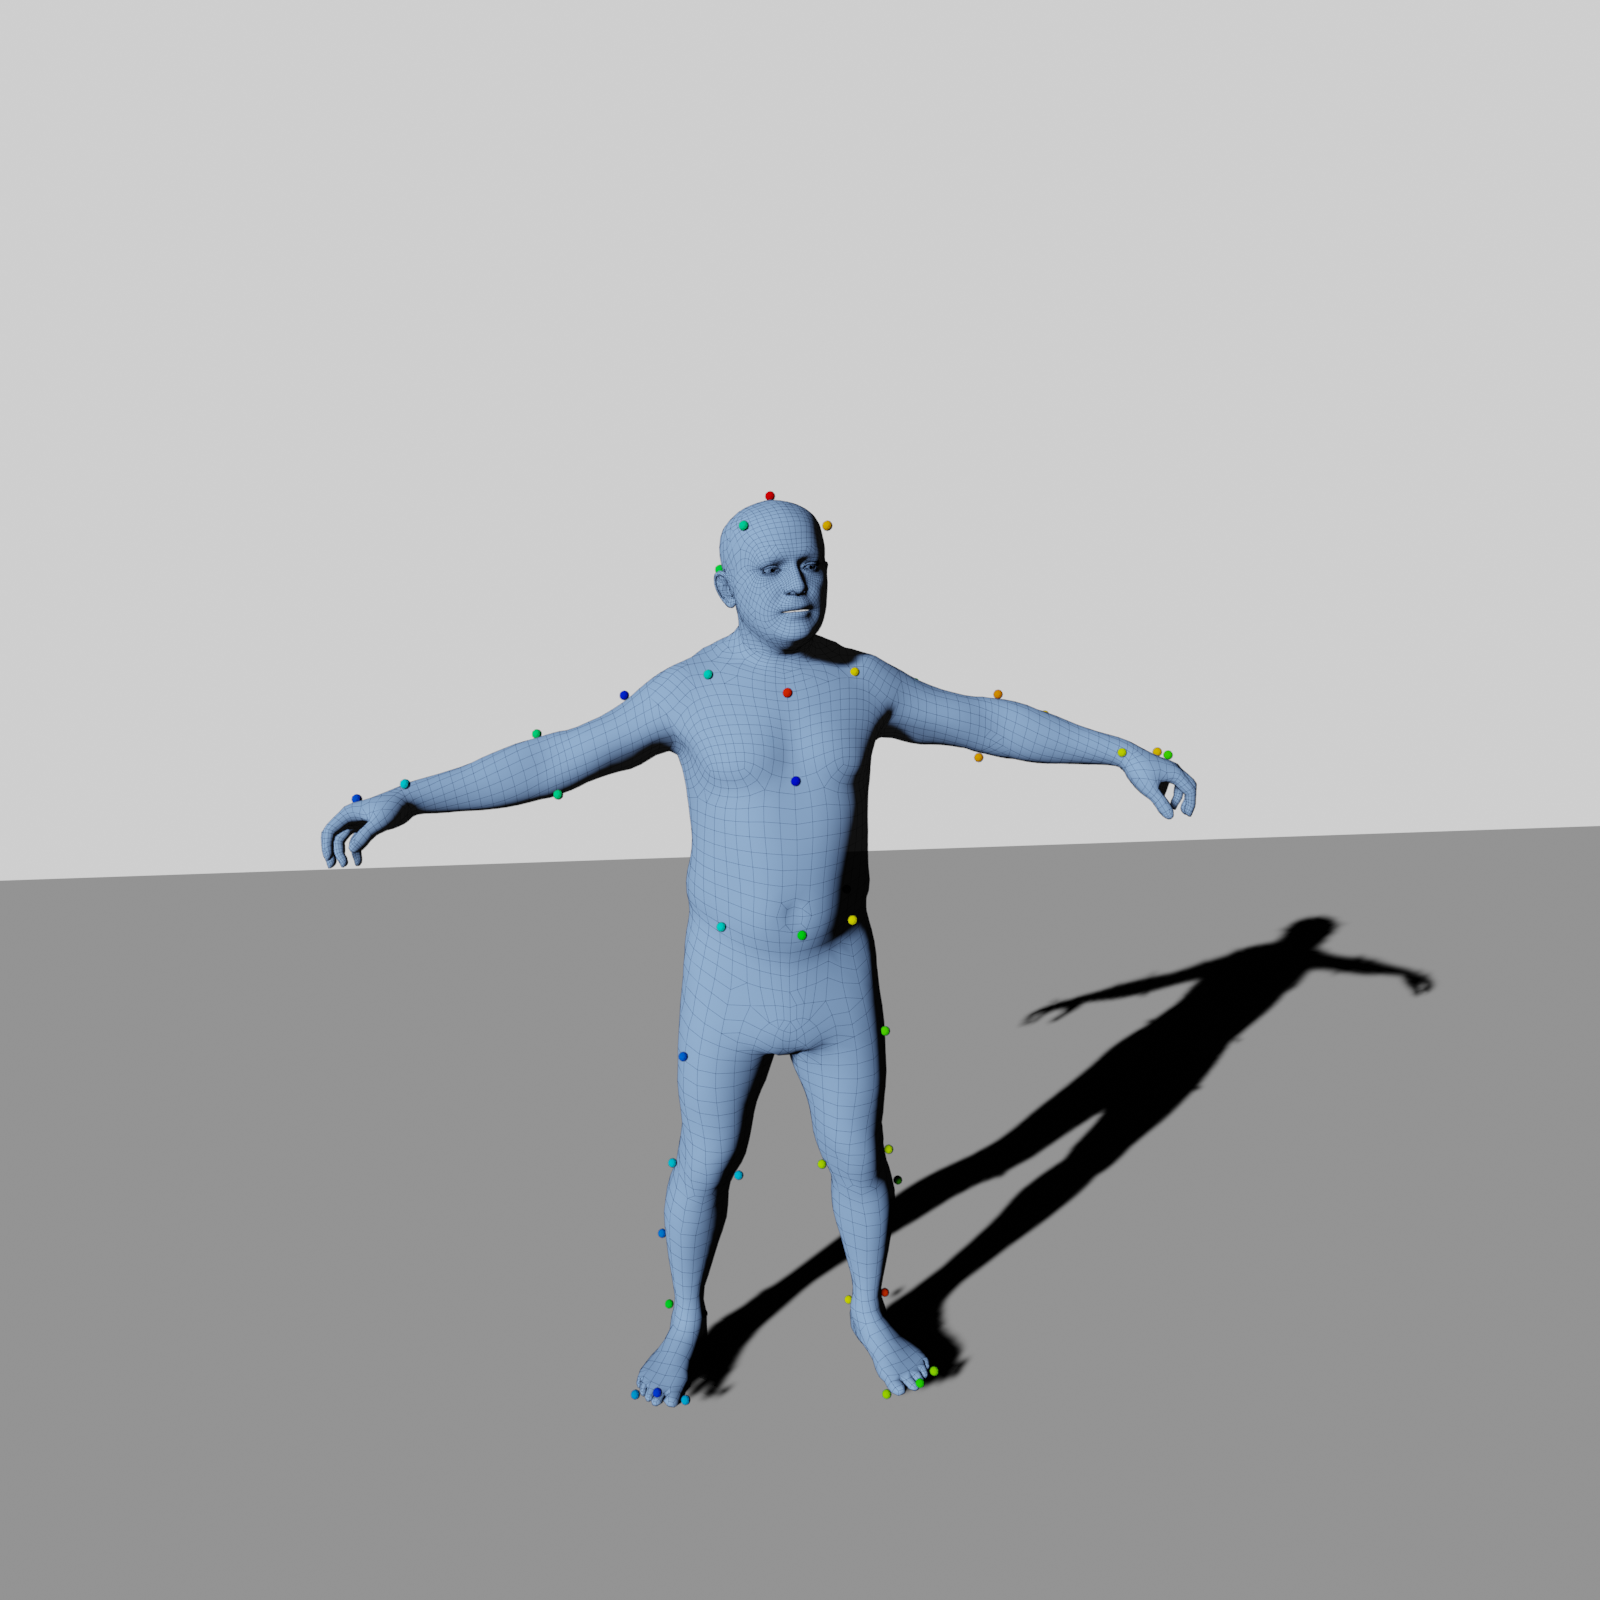

In [9]:
from glob import glob
import random
from IPython.display import Image

render_image_fnames = glob(osp.join(blender_temp_dir, 'SOMA_unlabeled_mpc', 'png_files', 'soma_standard', '*/*.png'))
print(f'Found {len(render_image_fnames)} rendered images. showing one!')

random.shuffle(render_image_fnames)
Image(filename=render_image_fnames[0]) 

You can use the
[AMASS tutorials](https://github.com/nghorbani/amass/blob/master/notebooks/01-AMASS_Visualization.ipynb)
and the [body visualizer](https://github.com/nghorbani/body_visualizer)
 to turn mosh pkl files into AMASS npz format on the fly and render in Jupyter. Let's have a look.

In [6]:
from moshpp.mosh_head import MoSh
import numpy as np

mosh_stageii_pkl_fname = osp.join(soma_work_base_dir, 'training_experiments/V48_02_SOMA/OC_05_G_03_real_000_synt_100/evaluations/mosh_results_tracklet/SOMA_unlabeled_mpc/soma_subject1/clap_001_stageii.pkl')
mosh_result = MoSh.load_as_amass_npz(mosh_stageii_pkl_fname, include_markers=True)
print({k:v if isinstance(v, str) or isinstance(v,float) or isinstance(v,int) else v.shape for k,v in mosh_result.items() if not isinstance(v, list) and not isinstance(v,dict)})

time_length = len(mosh_result['trans'])
mosh_result['betas'] = np.repeat(mosh_result['betas'][None], repeats=time_length, axis=0)

subject_gender = mosh_result['gender']
surface_model_type = mosh_result['surface_model_type']
print(f'subject_gender: {subject_gender}, surface_model_type: {surface_model_type}, time_length: {time_length}')

{'gender': 'male', 'surface_model_type': 'smplx', 'mocap_frame_rate': 120.0, 'mocap_time_length': 10.575, 'markers_latent': (53, 3), 'trans': (1269, 3), 'poses': (1269, 165), 'betas': (16,), 'num_betas': 16, 'root_orient': (1269, 3), 'pose_body': (1269, 63), 'pose_hand': (1269, 90), 'pose_jaw': (1269, 3), 'pose_eye': (1269, 6), 'markers': (1269, 53, 3), 'num_markers': 53}
subject_gender: male, surface_model_type: smplx, time_length: 1269


In [7]:
import trimesh
from body_visualizer.tools.vis_tools import colors
from body_visualizer.mesh.mesh_viewer import MeshViewer
from body_visualizer.mesh.sphere import points_to_spheres
from body_visualizer.tools.vis_tools import show_image

imw, imh=1600, 1600
mv = MeshViewer(width=imw, height=imh, use_offscreen=True)

In [8]:
from human_body_prior.body_model.body_model import BodyModel
import torch
from human_body_prior.tools.omni_tools import copy2cpu as c2c 

comp_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


bm_fname = osp.join(soma_work_base_dir, f'support_files/{surface_model_type}/{subject_gender}/model.npz')

num_betas = mosh_result['num_betas'] # number of body parameters

bm = BodyModel(bm_fname=bm_fname, num_betas=num_betas).to(comp_device)
faces = c2c(bm.f)

In [9]:
body_parms = {k:torch.Tensor(v).to(comp_device) for k,v in mosh_result.items() if k in ['pose_body', 'betas', 'pose_hand']}
print({k:v.shape for k,v in body_parms.items()})

{'betas': torch.Size([1269, 16]), 'pose_body': torch.Size([1269, 63]), 'pose_hand': torch.Size([1269, 90])}


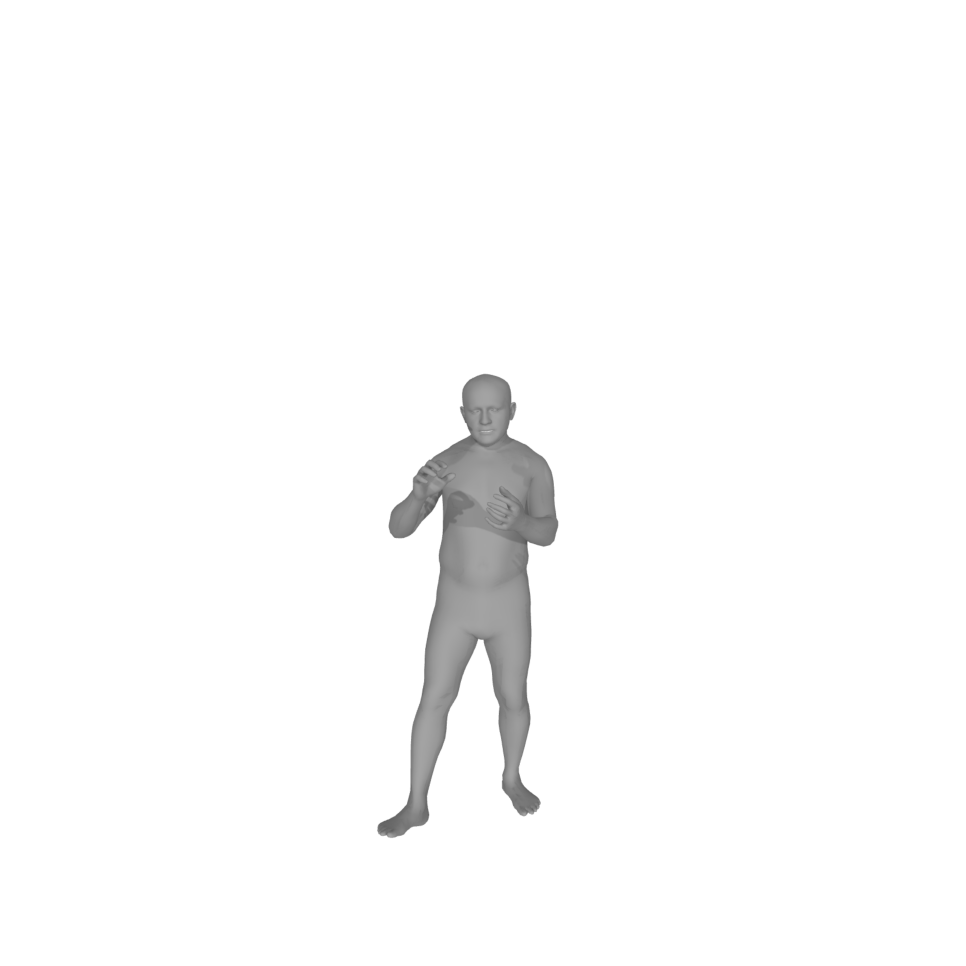

In [10]:
body_pose_hand = bm(**body_parms)

def vis_body_pose_hand(fId = 0):
    body_mesh = trimesh.Trimesh(vertices=c2c(body_pose_hand.v[fId]), faces=faces, vertex_colors=np.tile(colors['grey'], (6890, 1)))
    mv.set_static_meshes([body_mesh])
    body_image = mv.render(render_wireframe=False)
    show_image(body_image)

vis_body_pose_hand(fId=100)

You can change the *fId* to render another frame. 